In [29]:
%store -r
%who

Con	 FontManager	 ID	 Pt_included	 Pt_medical_info	 Scale	 Scale_Filtered	 Scale_hc	 Scale_pt	 
Scale_pt_2	 ancova	 asia	 available	 columns_for_anal	 columns_neo	 create_describe	 create_result_df	 db	 
db_directory	 dbcr	 demogrphic_result_matrix	 fill_na_mean	 fm	 general	 general_vbm	 get_columns	 get_control_info	 
get_max	 get_mean	 get_patinet_info	 get_sig	 get_std	 hc_describe	 hc_pt1	 hc_pt_result	 hc_pt_result_2	 
i	 injured_seg	 labels	 mat_fonts	 matplotlib	 missing_pt_1	 multivariate_normality	 n	 np	 
nreps	 ols	 os	 output	 partial_corr	 pd	 pg	 plot_sig	 plt	 
post_test	 pre_test	 psq	 pt12_contrast_df	 pt12_contrast_result	 pt1_describe	 pt_coefficient_matrix	 pt_coefficient_matrix_partial	 pt_norm_matrix	 
pt_p_matrix	 pt_p_matrix_partial	 pt_p_matrix_perm	 result_df	 robjects	 save_fig	 save_table	 scale	 scale_mean	 
scale_std	 scales	 seg_count	 size	 sns	 sql	 sqlite3	 start	 stats	 
subprocess	 tbss_data	 time	 total_width	 vbm	 vbm_coefficient_matrix	 vbm_contr

In [7]:
save_table(hc_pt_result,'健康人与前测')
save_table(hc_pt_result_2,"健康人与后测")
save_table(pt12_contrast_result,"患者前后测")

In [2]:
# -*- utf-8 -*-
import time
import os

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

import sqlite3

import pingouin as pg
from pingouin import ancova # anconva
from pingouin import multivariate_normality # for pearson correlation
from statsmodels.formula.api import ols # interaction effect
import rpy2.robjects as robjects # use basic R function

In [3]:
# notebook setup
start = time.time()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
pd.set_option('display.float_format', lambda x: '%.4f' % x) # set how many decimal places to keep
pd.options.mode.chained_assignment = None  # default='warn'; disalarm ' SettingWithCopyWarning'
# project setup
# connect to db
db_directory = r'../cleaned_data/SCI_pt.db'
db = sqlite3.connect(db_directory,timeout=30)
dbcr = db.cursor()

plt.rcParams["font.family"] = 'Noto Sans CJK JP'

!mkdir chart
!mkdir forplot
!mkdir table

np.random.seed(12345)
nreps=5000

mkdir: cannot create directory ‘chart’: File exists
mkdir: cannot create directory ‘forplot’: File exists
mkdir: cannot create directory ‘table’: File exists


In [4]:
from matplotlib.font_manager import FontManager
import subprocess

fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)
#print(mat_fonts)
output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"', shell=True)
#print( '*' * 10, '系统可用的中文字体', '*' * 10)
#print (output)
zh_fonts = set(f.split(',', 1)[0] for f in output.decode('utf-8').split('\n'))
available = mat_fonts & zh_fonts
print ('*' * 10, '可用的字体', '*' * 10)
available


********** 可用的字体 **********


{'Droid Sans Fallback', 'Noto Sans CJK JP'}

In [5]:
def save_table(df,name):
    df.to_csv('table/{}.csv'.format(name))
def save_fig(name):
    plt.savefig('chart/{}.svg'.format(name))

In [8]:
# get arrtributes of table
def get_columns(table_name):
    dbcr.execute("SELECT * FROM {}".format(table_name))
    col_list = [tuple[0] for tuple in dbcr.description]
    return col_list

def fill_na_mean(df, rd=2):
    for col in list(df.columns[df.isnull().sum() > 0]):
        mean_val = df[col].mean()
        df[col].fillna(round(mean_val,rd),inplace=True)
        
# Definate partial correlation function
def partial_corr(x, y, partial = []):
    # x，y are the variables we want to exam，partial is covariance
    xy, xyp = stats.pearsonr(x, y)
    xp, xpp = stats.pearsonr(x, partial)
    yp, ypp = stats.pearsonr(y, partial)
    n = len(x)
    df = n - 3
    r = (xy - xp*yp)/(np.sqrt(1 - xp*xp)*np.sqrt(1 - yp*yp))
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t = (r*np.sqrt(df))/np.sqrt(1 - r*r)
        prob = (1 - stats.t.cdf(abs(t),df))**2
    return r,prob

# According to the index(subjects' ID) of df，get corresponding demographic info we need
def get_patinet_info(df, arrtribute):
    return Pt_included.loc[[i for i in df.index if i[0] == 'P'], arrtribute]

def get_control_info(df, arrtribute):
    return Con.loc[[i for i in df.index if i[0] == 'C'], arrtribute]

In [9]:
# create result table
def create_result_df(reference_df,group_name):
    """
    group_name should be a list
    """
    column_number=len(group_name)
    row_number=len(reference_df.columns)
    df = pd.DataFrame(np.zeros(row_number*column_number).reshape(row_number,column_number))
    df.index=reference_df.columns
    df.columns = group_name
    return df



def create_describe(describe_df_list,result_df, decimal=2):
    def get_range(df, column, decimal=2):
        """
        return mean±std
        """
        return str(round(df.loc['mean',column],decimal))+'±'+str(round(df.loc['std',column],decimal))
    for i in range(2):
        group = result_df.columns[i]
        describe_df = describe_df_list[i]
        for col in describe_df.columns:
            value = get_range(describe_df,col, decimal)
            result_df.loc[col, group] = value

In [10]:
demogrphic_result_matrix.columns = ['患者组正态性检验','患者组正态检验p值','对照组正态性检验','对照组正态性检验p值','方差齐性检验','方差齐性检验p值','t检验','t检验p值','两独立样本置换检验p值']
demogrphic_result_matrix.index=['年龄','教育年限','身高','体重']
save_table(demogrphic_result_matrix,"一般资料的统计检验")
demogrphic_result_matrix

患者组正态性检验  患者组正态检验p值  对照组正态性检验  对照组正态性检验p值  方差齐性检验  方差齐性检验p值     t检验  \
年龄      0.9605     0.6109    0.9538      0.4285  0.0062    0.9375 -0.6465   
教育年限    0.8835     0.0299    0.9084      0.0593  6.6709    0.0140  0.8159   
身高      0.8977     0.0523    0.9507      0.3786  0.0460    0.8314  0.3122   
体重      0.9153     0.1067    0.9637      0.6193  0.0537    0.8181  0.3480   

      t检验p值  两独立样本置换检验p值  
年龄   0.5221       0.5136  
教育年限 0.4228       0.4324  
身高   0.7567       0.7754  
体重   0.7299       0.7442

In [12]:
general.columns = ['患者','健康对照组','统计量','p值']
general.index = ['样本数','年龄','性别 男/女','身高','体重','教育年限','利手 左/右']
general.loc['样本数',['患者','健康对照组']] = general.loc['样本数',['患者','健康对照组']].astype('int')
general.to_csv('table/general.csv')
general

患者                      健康对照组     统计量     p值
样本数                20                         18       /      /
年龄         56.35±9.49                54.28±10.27 -0.6465 0.5221
性别 男/女           14/6                       13/5  0.8974 1.0000
身高      167.05 ± 6.89  167.83333333333334 ± 8.56  0.3122 0.7567
体重       69.3 ± 12.66              70.75 ± 13.01  0.3480 0.7299
教育年限       10.95±2.16                 11.94±4.75  0.8159 0.4324
利手 左/右           19/1                       18/0  0.0000 1.0000

In [13]:
Pt_medical_info

MRI_Assessment ASIA_Pretest  \
PatientID                                                         
P_003      C3/4,C4/5,C5/6,C6/7,C7T1椎间盘向后膨出，颈椎退行性病变            D   
P_004                      C3/4,C4/5,C5/6,C6/7间盘突出            C   
P_013              C3/4,C4/5,C5/6,C6/7间盘突出变性，伴椎管狭窄            D   
P_014         C3/4,C4/5,C5/6椎间盘突出,变性、伴椎管稍狭窄、颈椎推行性变            D   
P_018            C3/4,C4/5,C5/6,C6/7椎间盘突出，伴脊髓伴脊髓变性            D   
P_021                            C5/6椎间盘突出，颈椎退行性病变            C   
P_007                          C4/5,C5/6,C6/7椎间盘突出            B   
P_009                                    C2/3后韧带骨化            D   
P_011                                    C4/5椎间盘突出            D   
P_019                     C3/4,C4/5,C5/6椎间盘突出伴椎管狭窄            D   
P_020            C4/5,C5/6,C6/7椎间盘突出伴椎管稍狭窄，颈椎退行性病变            D   
P_022        C3/4,C4/5,C5/6,C6/7椎间盘突出，变性伴椎管狭窄，脊髓受压            C   
P_016                         C4/5椎间盘突出，伴椎管狭窄，脊髓变性            D   
P_006                                           C6            D   
P_010                C3/4,C4/5,C5/6,C6/7椎间盘突出伴椎管狭窄            D   
P_015                          C3/4,C4/5,C5/6椎间盘突出            D   
P_023        C3/4,C4/5,C5/6,C6/7椎间盘突出伴椎管狭窄，以C4/5为重            D   
P_024                C4/5,C5/6,C6/7椎间盘突出，相应层面黄韧带肥厚            D   
P_027                 2/3，3/4，4/5，6/7椎间盘突出，5/6椎管狭窄            D   
P_028                        3/4，4/5，5/6椎间盘突出，脊髓水肿            D   

                            Sensory_Abonormality_Pretest  \
PatientID                                                  
P_003            双侧上臂、前臂、手部感觉麻木、针刺样疼痛，食指、中指、示指背侧疼痛感最重，拒触   
P_004             双上肢上臂痛觉过敏，前臂及双手浅感觉减退，锁骨以下水平浅感觉减退，深感觉无殊   
P_013            双上肢背侧、双下肢外侧浅感觉减退，双手背侧及掌侧痛觉过敏，左下肢足背浅感觉减退   
P_014                                       双手浅感觉减退，痛觉过敏   
P_018                                      四肢麻木刺痛感，较低踩棉花   
P_021                                         双手掌手背膝以下麻木   
P_007      双侧前臂及双手痛觉过敏，躯干脐平面以下、会阴区浅感觉、深感觉减退，双下肢浅感觉、深感觉消失   
P_009                                双上肢外侧浅感觉减退，双手指尖痛觉过敏   
P_011                                    双上肢上臂、前臂，双手痛觉过敏   
P_019                                   双臂只手背麻，刺痛，手心有烧灼感   
P_020                                      双手背侧刺痛麻热，右手严重   
P_022                                双手肩以下至手指尖麻痛触电感，背侧严重   
P_016                                 颈部疼，伴双侧手指疼，双手麻木三年余   
P_006                                       双上肢前臂痛觉过敏、乏力   
P_010                           双上肢感觉过敏，左上臂感觉明显，肩刺痛，双手刺痛   
P_015                左前臂外侧及左手第1-4指麻木不适，浅感觉减退、双上肢无力，左上部明显   
P_023                                       双手无力麻刺痛，有触电感   
P_024                                   手肘以下触痛，手部麻疼，手指最重   
P_027                                  双手小指浅感觉减退，四肢深感觉无殊   
P_028                                             四肢感觉减退   

                                                   Diagnosis  \
PatientID                                                      
P_003                                                  颈椎过伸伤   
P_004                               1.颈椎过伸伤伴颈脊髓损伤 2. 颈椎后韧带骨化   
P_013       1.颈椎过伸伤伴颈脊髓不完全损伤 2. 腰椎间盘突出症 3. 额骨骨折（左侧）4.肥大泡（双侧）   
P_014                       1.颈椎过伸伤伴颈髓损伤 2.右眼眶骨折 3.膀胱恶性肿瘤个人史   
P_018         1.颈椎过伸伤伴颈脊髓不完全损伤 2. 颈椎间盘突出 3. 面部软组织挫伤4.腰椎间盘突出症   
P_021      1.颈椎过伸伤伴颈脊髓损伤 2.头面部搓裂伤 3.颈椎退行性变 4. 2型糖尿病 5.高血压...   
P_007              1.颈椎过伸伤伴颈脊髓损伤 2. 颈椎后韧带骨化 3. 高血压病 4. 糖耐量异常   
P_009           1.颈椎过伸伤 2. 颈椎椎管狭窄 3. 颈椎后纵韧带骨化 4. 原发性甲状腺功能减退症   
P_011           1.颈椎过伸伤伴不完全颈脊髓损伤 2.高血压病 3. 2型糖尿病 4. 胆囊切除术后状态   
P_019                                  1.颈椎过伸伤伴颈脊髓损伤 2. 皮肤挫伤   
P_020                       1.颈椎过伸伴颈髓不完全损伤 2.高压病史 3.宫颈恶性肿瘤病史   
P_022                             1.颈椎过伸伤伴颈脊髓损伤 2. 颈椎后纵韧带骨化症   
P_016                             1.颈椎过伸伤伴颈脊髓不完全损伤 2. 脊髓型颈椎病   
P_006      1. 颈椎过伸伤伴颈脊髓损伤 2. 颈椎后纵韧带骨化 3. 高血压 4. 2型糖尿病 5.脑...   
P_010                         1. 颈椎过伸伤伴脊髓损伤 2. 高血压病 3. 甲状腺肿物   
P_015                                      1.颈部脊髓损伤 2.颈椎间盘突出   
P_023                     1.颈椎过伸伤伴脊髓不完全损伤 2.颈椎间盘突出 3.面部软组织挫伤   
P_024                   

<AxesSubplot:title={'center':'患者的ASIA评级分布'}, ylabel='ASIA_Pretest'>

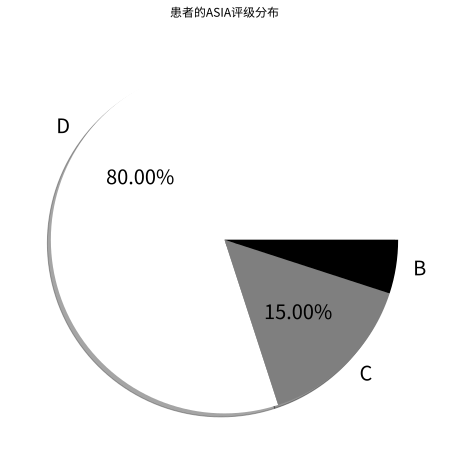

In [12]:
plt.figure(figsize=(8,8),dpi= 80)
plt.axis('off')


plt.rcParams["font.family"] = 'Noto Sans CJK JP'
Pt_medical_info['ASIA_Pretest'].value_counts(normalize=True).plot(kind='pie', shadow=True, autopct='%.2f%%',
                                                                  title="患者的ASIA评级分布", colormap='gray_r',fontsize=20)
# plt.savefig('chart/ASIA.svg')

损伤节段统计：


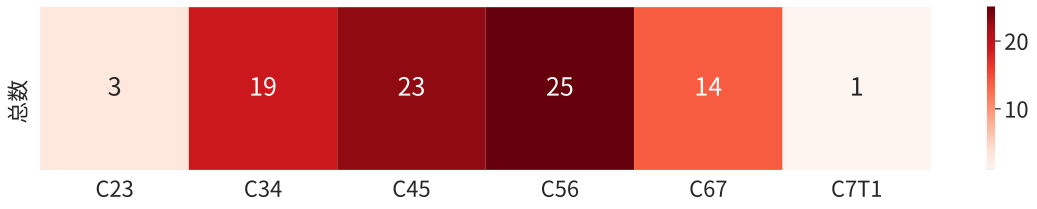

In [13]:
def inj(pos):
    return Injury_sum.sum()[pos]

print("损伤节段统计：")
sql = 'SELECT * FROM Injury_Summary'
dbcr.execute(sql)
Injury_sum = pd.DataFrame(dbcr.fetchall(),columns=get_columns('Injury_Summary')).set_index(['ID'])
Injury_sum_heatmap_df = pd.DataFrame([[inj("C23"),inj("C34"),inj("C45"),inj("C56"),inj("C67"),inj("C7T1")]],columns=Injury_sum.columns[5:],index=['Sum'])

for col in Injury_sum_heatmap_df.columns:
    Injury_sum_heatmap_df[[col]] = Injury_sum_heatmap_df[col].map(lambda x:'{:.0f}'.format(x)).astype(int) 

plt.figure(figsize=(20,3), dpi= 80)

sns.set(font_scale=2)
plt.rcParams["font.family"] = 'Noto Sans CJK JP'
Injury_sum_heatmap_df.index = ['总数']
sns.heatmap(Injury_sum_heatmap_df, cmap='Reds', annot=True, annot_kws={"fontsize":25})
save_fig("损伤节段热图")

<AxesSubplot:ylabel='SUM'>

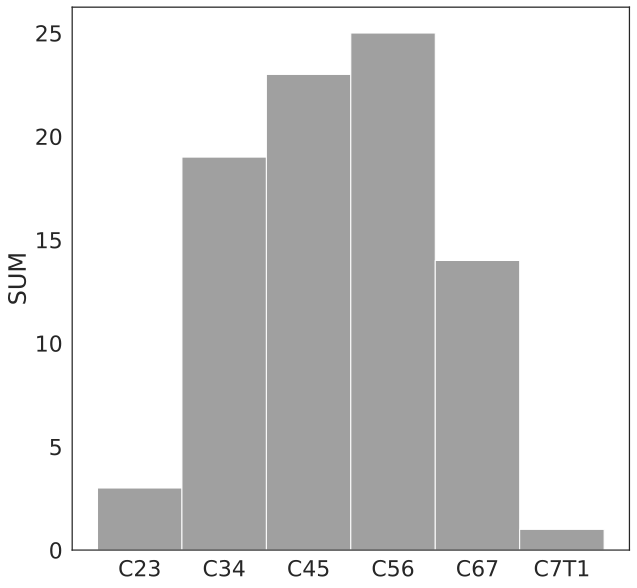

In [14]:
plt.figure(figsize=(10,10), dpi= 80)
plt.rcParams["font.family"] = 'Noto Sans CJK JP'
sns.set_style("white")
plt.ylabel('SUM')
hist_data = []
for seg in ["C23","C34","C45","C56","C67","C7T1"]:
    hist_data += [seg for i in range(int(inj(seg)))]
sns.histplot(hist_data, color='gray')
# plt.savefig('chart/Injury_sum_hist.svg')

# 问卷数据

In [17]:
# 获取患者的基本信息 
sql = "select * from Patient where Included=1 and Demographic_Full=1"
dbcr.execute(sql)
Pt_included = pd.DataFrame(map(list,dbcr.fetchall()),columns=get_columns('Patient')).set_index(['PatientID'])

sql = "select * from Control where Data_Condition='全'"
dbcr.execute(sql)
Con = pd.DataFrame(map(list,dbcr.fetchall()),columns=get_columns('Control'))[['ControlID', 'Gender', 'Age', 'Year_of_Education', 'Dominant_Hand']].set_index(['ControlID'])

ID = list(Pt_included.index) + list(Con.index)
# get columns we want to analyse and reorder them.
columns_for_anal = ['timepoint','VAS','SFMPQ','PDQ', 'PSQ','FPQ_Severe', 'FPQ_Mild', 'FPQ_Medical', 'FPQ_Total',
    'PCS_1', 'PCS_2', 'PCS_3', 'PCS_Total', 'PASS', 'PVAQ', 'SAI','TAI', 'HAMA', 'HAMD','BDI', 'LOT_R','PSQI']
# drop NEO data here, because there are too many missing value, and I am going to fill missing value with group mean
columns_neo = ['NEO_1','NEO_2','NEO_3','NEO_4','NEO_5']

In [18]:
# get the data of all scales
sql = 'SELECT * FROM Scale '
dbcr.execute(sql)
Scale = pd.DataFrame(dbcr.fetchall(), columns=get_columns('Scale'))

Scale_Filtered = Scale[Scale['ID'].isin(ID)]
Scale_Filtered = Scale_Filtered[~Scale_Filtered['timepoint'].isin([4])].set_index(['ID']) # 有一个两次后测2的   通过~取反，选取不包含数字4的行

## 健康人与患者前测数据比较
患者17,健康人12，下表为健康人数据

In [19]:
Scale_hc = Scale_Filtered[Scale_Filtered['timepoint']==0].drop(columns_neo, axis=1)[columns_for_anal]
Scale_pt = Scale_Filtered[Scale_Filtered['timepoint']==1].drop(columns_neo, axis=1)[columns_for_anal]
missing_pt_1= pd.DataFrame(Scale_pt.isnull().sum(axis=0), columns=['患者时点1']).drop(index='timepoint').T
fill_na_mean(Scale_pt)
scales = Scale_pt.columns[1:]

In [20]:
Scale_hc

timepoint    VAS  SFMPQ    PDQ      PSQ  FPQ_Severe  FPQ_Mild  \
ID                                                                     
C_001          0 0.0000 0.0000 0.0000  90.0000     44.0000   31.0000   
C_002          0 0.0000 0.0000 0.0000  70.0000     36.0000   19.0000   
C_003          0 0.0000 0.0000 0.0000  81.0000     47.0000   31.0000   
C_004          0 0.0000 0.0000 0.0000  57.0000     23.0000   14.0000   
C_005          0 0.0000 0.0000 0.0000  82.0000     45.0000   19.0000   
C_006          0 0.0000 0.0000 0.0000  85.0000     37.0000   25.0000   
C_007          0 0.0000 0.0000 0.0000  65.0000     44.0000   26.0000   
C_009          0 0.0000 0.0000 0.0000  97.0000     43.0000   34.0000   
C_010          0 0.0000 0.0000 0.0000  60.0000     32.0000   16.0000   
C_011          0 0.0000 0.0000 0.0000  41.0000     17.0000   12.0000   
C_012          0 0.0000 0.0000 0.0000  57.0000     36.0000   27.0000   
C_013          0 0.0000 0.0000 0.0000  63.0000     44.0000   24.0000   
C_014          0 0.0000 0.0000 0.0000  67.0000     37.0000   26.0000   
C_015          0 0.0000 0.0000 0.0000  56.0000     28.0000   14.0000   
C_016          0 0.0000 0.0000 0.0000  80.0000     27.0000   28.0000   
C_017          0 0.0000 0.0000 0.0000  81.0000     36.0000   12.0000   
C_018          0 0.0000 0.0000 0.0000 102.0000     44.0000   36.0000   
C_019          0 0.0000 0.0000 0.0000 100.0000     43.0000   30.0000   

       FPQ_Medical  FPQ_Total   PCS_1   PCS_2   PCS_3  PCS_Total    PASS  \
ID                                                                         
C_001      33.0000   108.0000  4.0000  1.0000  5.0000    11.0000  0.0000   
C_002      19.0000    74.0000  0.0000  2.0000  1.0000     3.0000 28.0000   
C_003      44.0000   123.0000  1.0000  0.0000  1.0000     2.0000 13.0000   
C_004      25.0000    62.0000  6.0000  1.0000 12.0000    19.0000  9.0000   
C_005      33.0000    97.0000  6.0000  6.0000 10.0000    22.0000 38.0000   
C_006      26.0000    88.0000  4.0000  1.0000  3.0000     8.0000  8.0000   
C_007      25.0000    95.0000  4.0000 12.0000 11.0000    27.0000 26.0000   
C_009      45.0000   122.0000  8.0000  0.0000  0.0000     8.0000 64.0000   
C_010      18.0000    66.0000  5.0000  3.0000  3.0000    11.0000 31.0000   
C_011      11.0000    40.0000  5.0000  3.0000  3.0000    11.0000 25.0000   
C_012      27.0000    90.0000 12.0000  6.0000  4.0000    22.0000 20.0000   
C_013      26.0000    94.0000  7.0000  7.0000 14.0000    28.0000 64.0000   
C_014      32.0000    95.0000  0.0000  0.0000  0.0000     0.0000 15.0000   
C_015      14.0000    56.0000  7.0000  5.0000  5.0000    21.0000 48.0000   
C_016      37.0000    92.0000  5.0000  0.0000  8.0000    16.0000 25.0000   
C_017      16.0000    64.0000  4.0000  0.0000  6.0000    13.0000 36.0000   
C_018      35.0000   115.0000  9.0000  4.0000  5.0000    25.0000 53.0000   
C_019      33.0000   106.0000 12.0000  7.0000 19.0000    48.0000 75.0000   

         PVAQ     SAI     TAI   HAMA   HAMD     BDI   LOT_R    PSQI  
ID                                                                   
C_001 15.0000 20.0000 21.0000 0.0000 0.0000  3.0000 25.0000  5.0000  
C_002 27.0000 20.0000 22.0000 0.0000 0.0000  0.0000 30.0000  1.0000  
C_003 14.0000 23.0000 25.0000 0.0000 0.0000  1.0000 22.0000  7.0000  
C_004 38.0000 20.0000 29.0000 0.0000 0.0000  0.0000 20.0000  4.0000  
C_005 21.0000 24.0000 40.0000 1.0000 3.0000  6.0000 23.0000  3.0000  
C_006 38.0000 25.0000 26.0000 0.0000 0.0000  0.0000 24.0000  6.0000  
C_007 16.0000 20.0000 23.0000 0.0000 0.0000  2.0000 25.0000  2.0000  
C_009 57.0000 20.0000 34.0000 0.0000 0.0000  4.0000 21.0000  9.0000  
C_010 43.0000 20.0000 50.0000 1.0000 2.0000  4.0000 19.0000 10.0000  
C_011 43.0000 20.0000 35.0000 1.0000 2.0000  5.0000 19.0000  4.0000  
C_012 18.0000 20.0000 22.0000 0.0000 0.0000  3.0000 19.0000  3.0000  
C_013 48.0000 23.0000 39.0000 0.0000 0.0000  0.0000 20.0000  6.0000  
C_014 14.0000 53.0000 60.0000 0.0000 0.0000  2.0000 22.0000  6.00

In [23]:
hc_describe=Scale_hc.describe()
pt1_describe = Scale_pt.describe()
hc_pt_df = hc_pt_df[['pt_norm_stat', 'pt_norm_p', 'hc_norm_stat', 'hc_norm_p', 'levene_stat','levene_p', 'ind_t', 'ind_t_p', 'perm_ind_t_p', 'ancova_p']]
hc_pt_df.columns = ['患者组正态性检验','患者组正态性检验p值','对照组正态性检验','对照组正态性检验p值','方差齐性检验','方差齐性检验p值','t检验','t检验p值','两独立样本置换检验p值', '协方差分析p值']

NameError: name 'hc_pt_df' is not defined

In [22]:
result_df = create_result_df(pt1_describe, ['患者','健康受试者'])
create_describe([pt1_describe,hc_describe],result_df)
hc_pt1=result_df.join(hc_pt_result)
# save_table(hc_pt1,'健康人对前测数据')
hc_pt1

患者        健康受试者 healthy control        patient  t value  \
timepoint        1.0±0.0      0.0±0.0             NaN            NaN      NaN   
VAS          56.25±26.25      0.0±0.0       0.0 ± 0.0  56.25 ± 26.25  -8.8400   
SFMPQ        73.06±33.79      0.0±0.0       0.0 ± 0.0  73.06 ± 33.79  -8.9100   
PDQ           16.76±8.71      0.0±0.0       0.0 ± 0.0   16.76 ± 8.71  -7.9400   
PSQ          67.53±29.77  74.11±17.18   74.11 ± 17.18  67.53 ± 29.77   0.8100   
FPQ_Severe   30.42±10.93   36.83±8.53    36.83 ± 8.53  30.42 ± 10.93   1.9400   
FPQ_Mild       19.33±6.6   23.56±7.71    23.56 ± 7.71    19.33 ± 6.6   1.7400   
FPQ_Medical    23.5±8.71   27.72±9.71    27.72 ± 9.71    23.5 ± 8.71   1.3500   
FPQ_Total    73.25±24.82  88.17±23.43   88.17 ± 23.43  73.25 ± 24.82   1.8300   
PCS_1          6.17±2.71     5.5±3.42      5.5 ± 3.42    6.17 ± 2.71  -0.6400   
PCS_2          3.42±2.66    3.22±3.37     3.22 ± 3.37    3.42 ± 2.66  -0.1900   
PCS_3           6.5±4.52    6.11±5.26     6.11 ± 5.26     6.5 ± 4.52  -0.2300   
PCS_Total      16.08±8.8  16.39±11.65   16.39 ± 11.65    16.08 ± 8.8   0.0900   
PASS         29.45±15.76  32.11±21.31   32.11 ± 21.31  29.45 ± 15.76   0.4200   
PVAQ         40.55±10.53   33.5±15.34    33.5 ± 15.34  40.55 ± 10.53  -1.5900   
SAI          38.25±14.95   31.17±14.6    31.17 ± 14.6  38.25 ± 14.95  -1.4200   
TAI           30.91±3.34   39.0±14.71    39.0 ± 14.71   30.91 ± 3.34   2.2700   
HAMA           5.47±6.39     0.39±0.7      0.39 ± 0.7    5.47 ± 6.39  -3.2600   
HAMD            5.27±6.5    0.56±0.98     0.56 ± 0.98     5.27 ± 6.5  -2.9500   
BDI            7.65±6.41     3.0±2.87      3.0 ± 2.87    7.65 ± 6.41  -2.7900   
LOT_R         22.27±2.43   21.72±3.63    21.72 ± 3.63   22.27 ± 2.43  -0.5200   
PSQI           4.38±1.44    5.56±2.99     5.56 ± 2.99    4.38 ± 1.44   1.4900   

             p value  ancova p value  
timepoint        NaN             NaN  
VAS           0.0000          0.0000  
SFMPQ         0.0000          0.0000  
PDQ           0.0000          0.0000  
PSQ           0.4258          0.4267  
FPQ_Severe    0.0650          0.0792  
FPQ_Mild      0.0919          0.1131  
FPQ_Medical   0.1998          0.2325  
FPQ_Total     0.0764          0.0990  
PCS_1         0.5236          0.5994  
PCS_2         0.8540          0.7848  
PCS_3         0.8164          0.8747  
PCS_Total     0.9308          0.8579  
PASS          0.6790          0.6445  
PVAQ          0.1218          0.1574  
SAI           0.1690          0.1995  
TAI           0.0350          0.0203  
HAMA          0.0000          0.0028  
HAMD          0.0010          0.0063  
BDI           0.0070          0.0107  
LOT_R         0.6018          0.6260  
PSQI          0.1492          0.1369

健康人与患者对比有显著差异的评分：
* SAI
* HAMA
* BDI
  
边缘显著的评分：
* FPQ 严重疼痛 及 总分
* PVAQ
* HAMD （协方差不显著）

大五人格的结果，患者与健康人神经质评分有显著差异，与焦虑量表的显著差异一致。

## 患者tp1 和tp2 对比

In [21]:
# get paierd patient ID
SF = Scale_Filtered.copy()
tp1_id = SF[SF['timepoint'].isin([1])].index
tp2_id = SF[SF['timepoint'].isin([2])].index
paired = [i for i in tp1_id if i in tp2_id]
        
# get the corresponding data of the ID above
SF_Paired = SF.loc[paired]
SF_Paired = SF_Paired[SF_Paired['timepoint'].isin([1,2])].drop(columns_neo, axis=1)[columns_for_anal]
missing_paired = pd.DataFrame(SF_Paired.isnull().sum(axis=0), columns=['配对数据']).drop(index='timepoint').T
pre_test = SF_Paired[SF_Paired['timepoint']==1]
post_test = SF_Paired[SF_Paired['timepoint']==2]

fill_na_mean(pre_test)
fill_na_mean(post_test)
pt12_contrast_df.columns = ['前测正态性检验','前测正态性检验p值','后测正态性检验',
                            '后测正态性检验p值','配对t检验','配对t检验p值','配对样本置换检验p值']
# save_table(pt12_contrast_df, 'pt12')
pt12_contrast_df

前测正态性检验  前测正态性检验p值  后测正态性检验  后测正态性检验p值   配对t检验  配对t检验p值  \
VAS           0.9444     0.5578   0.8980     0.1493  4.4948   0.0009   
SFMPQ         0.9583     0.7597   0.8976     0.1479  5.2566   0.0003   
PDQ           0.8537     0.0408   0.9256     0.3356  4.9719   0.0004   
PSQ           0.9726     0.9362   0.9425     0.5305  1.4867   0.1652   
FPQ_Severe    0.9236     0.3173   0.9291     0.3710 -2.7178   0.0200   
FPQ_Mild      0.8599     0.0487   0.9034     0.1755 -1.1237   0.2851   
FPQ_Medical   0.8519     0.0388   0.9061     0.1900  0.4648   0.6511   
FPQ_Total     0.9223     0.3053   0.9529     0.6798 -1.1779   0.2637   
PCS_1         0.8257     0.0186   0.9630     0.8258 -0.6032   0.5586   
PCS_2         0.9447     0.5608   0.8866     0.1066 -0.9512   0.3619   
PCS_3         0.8962     0.1417   0.9232     0.3138 -0.3783   0.7124   
PCS_Total     0.9640     0.8385   0.9489     0.6207 -0.6846   0.5077   
PASS          0.9121     0.2267   0.9506     0.6457  0.7554   0.4659   
PVAQ          0.8338     0.0233   0.9538     0.6935  1.2503   0.2371   
SAI           0.9022     0.1695   0.7866     0.0066  1.7162   0.1141   
TAI           0.8549     0.0422   0.8568     0.0445  0.7218   0.4855   
HAMA          0.8593     0.0479   0.8782     0.0830  2.2452   0.0463   
HAMD          0.8198     0.0159   0.6159     0.0001  1.0518   0.3154   
BDI           0.7880     0.0069   0.6832     0.0006  1.2123   0.2508   
LOT_R         0.8410     0.0285   0.9450     0.5648 -0.6377   0.5367   
PSQI          0.9098     0.2123   0.9296     0.3762 -2.3144   0.0410   

             配对样本置换检验p值  
VAS              0.0008  
SFMPQ            0.0006  
PDQ              0.0004  
PSQ              0.0864  
FPQ_Severe       0.0062  
FPQ_Mild         0.1512  
FPQ_Medical      0.3234  
FPQ_Total        0.1312  
PCS_1            0.2794  
PCS_2            0.1826  
PCS_3            0.3694  
PCS_Total        0.2496  
PASS             0.2408  
PVAQ             0.1224  
SAI              0.0562  
TAI              0.2382  
HAMA             0.0204  
HAMD             0.1596  
BDI              0.1138  
LOT_R            0.2736  
PSQI             0.0218

In [22]:
pre_describe=pre_test.describe()
post_describe=post_test.describe()

result_df_1 = create_result_df(pre_describe, ['患者前测数据','患者后测数据'])
create_describe([pre_describe,post_describe],result_df_1)
pt12=result_df_1.join(pt12_contrast_df)
#save_table(pt12,'患者前后测数据')
pt12

患者前测数据       患者后测数据  前测正态性检验  前测正态性检验p值  后测正态性检验  后测正态性检验p值  \
timepoint        1.0±0.0      2.0±0.0      nan        nan      nan        nan   
VAS          62.92±24.16  23.75±20.42   0.9444     0.5578   0.8980     0.1493   
SFMPQ         80.67±33.4  34.58±30.55   0.9583     0.7597   0.8976     0.1479   
PDQ            19.42±8.2    9.33±6.64   0.8537     0.0408   0.9256     0.3356   
PSQ           69.1±30.25   58.0±25.45   0.9726     0.9362   0.9425     0.5305   
FPQ_Severe    27.29±8.97    32.4±7.34   0.9236     0.3173   0.9291     0.3710   
FPQ_Mild      18.86±5.71    21.0±8.11   0.8599     0.0487   0.9034     0.1755   
FPQ_Medical   23.29±7.05   22.3±10.18   0.8519     0.0388   0.9061     0.1900   
FPQ_Total    69.43±21.03   74.7±23.08   0.9223     0.3053   0.9529     0.6798   
PCS_1          6.25±2.25    7.18±4.74   0.8257     0.0186   0.9630     0.8258   
PCS_2          3.38±2.17    4.45±4.12   0.9447     0.5608   0.8866     0.1066   
PCS_3          7.25±4.82     7.73±5.4   0.8962     0.1417   0.9232     0.3138   
PCS_Total     16.88±7.99   19.36±13.1   0.9640     0.8385   0.9489     0.6207   
PASS         34.14±16.13   30.8±15.83   0.9121     0.2267   0.9506     0.6457   
PVAQ          39.0±10.24   33.82±9.37   0.8338     0.0233   0.9538     0.6935   
SAI          39.82±16.04  30.71±10.49   0.9022     0.1695   0.7866     0.0066   
TAI           33.29±2.28   31.89±6.64   0.8549     0.0422   0.8568     0.0445   
HAMA           6.64±7.24    2.36±2.23   0.8593     0.0479   0.8782     0.0830   
HAMD           6.09±7.45    3.82±6.78   0.8198     0.0159   0.6159     0.0001   
BDI            8.58±6.75     5.92±6.8   0.7880     0.0069   0.6832     0.0006   
LOT_R         21.57±2.13    22.11±3.4   0.8410     0.0285   0.9450     0.5648   
PSQI            5.0±1.21    8.82±5.02   0.9098     0.2123   0.9296     0.3762   

              配对t检验  配对t检验p值  配对样本置换检验p值  
timepoint       nan      nan         nan  
VAS          4.4948   0.0009      0.0008  
SFMPQ        5.2566   0.0003      0.0006  
PDQ          4.9719   0.0004      0.0004  
PSQ          1.4867   0.1652      0.0864  
FPQ_Severe  -2.7178   0.0200      0.0062  
FPQ_Mild    -1.1237   0.2851      0.1512  
FPQ_Medical  0.4648   0.6511      0.3234  
FPQ_Total   -1.1779   0.2637      0.1312  
PCS_1       -0.6032   0.5586      0.2794  
PCS_2       -0.9512   0.3619      0.1826  
PCS_3       -0.3783   0.7124      0.3694  
PCS_Total   -0.6846   0.5077      0.2496  
PASS         0.7554   0.4659      0.2408  
PVAQ         1.2503   0.2371      0.1224  
SAI          1.7162   0.1141      0.0562  
TAI          0.7218   0.4855      0.2382  
HAMA         2.2452   0.0463      0.0204  
HAMD         1.0518   0.3154      0.1596  
BDI          1.2123   0.2508      0.1138  
LOT_R       -0.6377   0.5367      0.2736  
PSQI        -2.3144   0.0410      0.0218

患者治疗前后有显著差异的评分：
* VAS
* SFMPQ
* PDQ
* FPQ 严重疼痛
* HAMA 
* PSQI   

边缘显著的评分：
* PSQ （permuation test）
* SAI （permuation test）

样本量较少，置换检验与普通配对t的结果有一定差异

结果说明患者治疗前后疼痛有明显的缓解。 焦虑状态、对严重疼痛的认知有所改善， 睡眠质量有所提升。



## 健康人与患者时点2对比

In [23]:
# Scale_hc contains data of health control 
Scale_pt_2 = Scale_Filtered[Scale_Filtered['timepoint']==2]
missing_pt_2 = pd.DataFrame(Scale_pt_2.isnull().sum(axis=0), columns=['患者时点2']).drop(index='timepoint').T
fill_na_mean(Scale_pt_2)
Scale_pt_2 = Scale_pt_2[columns_for_anal]

In [24]:
hc_pt_result_2 = hc_pt_result_2[['pt_norm_stat', 'pt_norm_p', 'hc_norm_stat', 'hc_norm_p', 'levene_stat','levene_p', 'ind_t', 'ind_t_p', 'perm_ind_t_p', 'ancova_p']]
hc_pt_result_2.columns = ['患者组正态性检验','患者组正态性检验p值','对照组正态性检验','对照组正态性检验p值','方差齐性检验','方差齐性检验p值','t检验','t检验p值','两独立样本置换检验p值', '协方差分析p值']


In [25]:
save_table(hc_pt_result_2, 'hc_pt_2')
hc_pt_result_2

患者组正态性检验  患者组正态性检验p值  对照组正态性检验  对照组正态性检验p值  方差齐性检验  方差齐性检验p值  \
VAS            0.8690      0.0327    1.0000      1.0000  8.2245    0.0083   
SFMPQ          0.9066      0.1202    1.0000      1.0000 27.2146    0.0000   
PDQ            0.9073      0.1232    1.0000      1.0000 12.4893    0.0016   
PSQ            0.9375      0.3521    0.9651      0.8536  1.1917    0.2854   
FPQ_Severe     0.9544      0.5960    0.8531      0.0401  0.6994    0.4109   
FPQ_Mild       0.9028      0.1051    0.9553      0.7151  0.0328    0.8576   
FPQ_Medical    0.9189      0.1855    0.9388      0.4829  0.0047    0.9461   
FPQ_Total      0.9505      0.5319    0.9601      0.7851  0.1106    0.7422   
PCS_1          0.9578      0.6549    0.9481      0.6094  2.3097    0.1411   
PCS_2          0.8883      0.0632    0.8584      0.0467  0.6922    0.4133   
PCS_3          0.8778      0.0439    0.8752      0.0761  0.7652    0.3900   
PCS_Total      0.9183      0.1813    0.9199      0.2847  4.1582    0.0521   
PASS           0.9704      0.8638    0.9048      0.1831  0.2219    0.6417   
PVAQ           0.9652      0.7814    0.9085      0.2041  4.0819    0.0542   
SAI            0.7830      0.0022    0.6842      0.0006  3.4683    0.0744   
TAI            0.8810      0.0490    0.8949      0.1364  2.1695    0.1533   
HAMA           0.8804      0.0480    0.5521      0.0000 14.0063    0.0010   
HAMD           0.6012      0.0000    0.5968      0.0001  2.5043    0.1261   
BDI            0.6670      0.0001    0.8956      0.1392  1.0119    0.3241   
LOT_R          0.9772      0.9471    0.8792      0.0857  0.0280    0.8684   
PSQI           0.9090      0.1307    0.9627      0.8215  2.4691    0.1287   

                t检验  t检验p值  两独立样本置换检验p值  协方差分析p值  
VAS         -5.1105 0.0002       0.0000   0.0002  
SFMPQ       -4.3576 0.0007       0.0002   0.0015  
PDQ         -5.7725 0.0001       0.0000   0.0001  
PSQ          1.5769 0.1274       0.1262   0.2566  
FPQ_Severe   1.3340 0.1942       0.2064   0.5820  
FPQ_Mild     0.9001 0.3767       0.3724   0.7099  
FPQ_Medical  1.4713 0.1537       0.1552   0.3433  
FPQ_Total    1.4883 0.1492       0.1456   0.4050  
PCS_1       -1.2897 0.2090       0.2062   0.2875  
PCS_2       -0.7605 0.4540       0.4628   0.2889  
PCS_3       -1.2257 0.2317       0.2388   0.1902  
PCS_Total   -1.2400 0.2265       0.2420   0.1966  
PASS        -0.7331 0.4703       0.4782   0.2738  
PVAQ        -0.1740 0.8632       0.8622   0.8011  
SAI         -3.5734 0.0015       0.0000   0.0013  
TAI         -0.3648 0.7183       0.7204   0.5511  
HAMA        -3.4937 0.0031       0.0034   0.0023  
HAMD        -1.6326 0.1151       0.0776   0.1343  
BDI         -1.8761 0.0724       0.0358   0.0718  
LOT_R       -0.2404 0.8120       0.8044   0.7771  
PSQI        -1.8049 0.0832       0.0854   0.0885

In [26]:
pt2_describe=Scale_pt_2.describe()
result_df_2 = create_result_df(pre_describe, ['患者后测数据','健康受试者'])
create_describe([pt2_describe,hc_describe],result_df_2)
hc_pt2=result_df_2.join(hc_pt_result_2)
# save_table(hc_pt2,'健康人对后测数据')
hc_pt2

患者后测数据        健康受试者  患者组正态性检验  患者组正态性检验p值  对照组正态性检验  \
timepoint        2.0±0.0      0.0±0.0       nan         nan       nan   
VAS           23.89±18.1      0.0±0.0    0.8690      0.0327    1.0000   
SFMPQ         32.07±28.5      0.0±0.0    0.9066      0.1202    1.0000   
PDQ            8.93±5.99      0.0±0.0    0.9073      0.1232    1.0000   
PSQ          57.46±24.96  70.67±16.42    0.9375      0.3521    0.9651   
FPQ_Severe     33.0±7.51   37.33±9.38    0.9544      0.5960    0.8531   
FPQ_Mild      20.54±7.83   23.17±7.15    0.9028      0.1051    0.9553   
FPQ_Medical   22.15±9.45   27.67±9.96    0.9189      0.1855    0.9388   
FPQ_Total    74.92±21.97  88.25±24.51    0.9505      0.5319    0.9601   
PCS_1          7.21±4.72    5.17±3.13    0.9578      0.6549    0.9481   
PCS_2          4.64±4.08     3.5±3.61    0.8883      0.0632    0.8584   
PCS_3          8.14±5.79    5.58±4.83    0.8778      0.0439    0.8752   
PCS_Total     20.0±13.63   14.33±8.95    0.9183      0.1813    0.9199   
PASS         32.38±16.69  27.17±20.31    0.9704      0.8638    0.9048   
PVAQ         32.36±10.83   31.5±14.78    0.9652      0.7814    0.9085   
SAI           31.11±9.37   21.25±1.91    0.7830      0.0022    0.6842   
TAI           31.58±6.26    30.5±9.14    0.8810      0.0490    0.8949   
HAMA           2.17±2.06    0.25±0.45    0.8804      0.0480    0.5521   
HAMD            3.5±6.09    0.58±1.08    0.6012      0.0000    0.5968   
BDI             5.8±6.09    2.33±2.15    0.6670      0.0001    0.8956   
LOT_R         22.58±3.75   22.25±3.33    0.9772      0.9471    0.8792   
PSQI            7.86±4.9     5.0±2.73    0.9090      0.1307    0.9627   

             对照组正态性检验p值  方差齐性检验  方差齐性检验p值     t检验  t检验p值  两独立样本置换检验p值  协方差分析p值  
timepoint           nan     nan       nan     nan    nan          nan      nan  
VAS              1.0000  8.2245    0.0083 -5.1105 0.0002       0.0000   0.0002  
SFMPQ            1.0000 27.2146    0.0000 -4.3576 0.0007       0.0002   0.0015  
PDQ              1.0000 12.4893    0.0016 -5.7725 0.0001       0.0000   0.0001  
PSQ              0.8536  1.1917    0.2854  1.5769 0.1274       0.1262   0.2566  
FPQ_Severe       0.0401  0.6994    0.4109  1.3340 0.1942       0.2064   0.5820  
FPQ_Mild         0.7151  0.0328    0.8576  0.9001 0.3767       0.3724   0.7099  
FPQ_Medical      0.4829  0.0047    0.9461  1.4713 0.1537       0.1552   0.3433  
FPQ_Total        0.7851  0.1106    0.7422  1.4883 0.1492       0.1456   0.4050  
PCS_1            0.6094  2.3097    0.1411 -1.2897 0.2090       0.2062   0.2875  
PCS_2            0.0467  0.6922    0.4133 -0.7605 0.4540       0.4628   0.2889  
PCS_3            0.0761  0.7652    0.3900 -1.2257 0.2317       0.2388   0.1902  
PCS_Total        0.2847  4.1582    0.0521 -1.2400 0.2265       0.2420   0.1966  
PASS             0.1831  0.2219    0.6417 -0.7331 0.4703       0.4782   0.2738  
PVAQ             0.2041  4.0819    0.0542 -0.1740 0.8632       0.8622   0.8011  
SAI              0.0006  3.4683    0.0744 -3.5734 0.0015       0.0000   0.0013  
TAI              0.1364  2.1695    0.1533 -0.3648 0.7183       0.7204   0.5511  
HAMA             0.0000 14.0063    0.0010 -3.4937 0.0031       0.0034   0.0023  
HAMD             0.0001  2.5043    0.1261 -1.6326 0.1151       0.0776   0.1343  
BDI              0.1392  1.0119    0.3241 -1.8761 0.0724       0.0358   0.0718  
LOT_R            0.0857  0.0280    0.8684 -0.2404 0.8120       0.8044   0.7771  
PSQI             0.8215  2.4691    0.1287 -1.8049 0.0832       0.0854   0.0885

健康人VAS SFMPQ PDQ 均为0, 显著差异   

**显著的评分**
* SAI
* HAMA
* BDI (协方差分析边缘显著)
   
**边缘显著评分**
* HAMD (置换检验\协方差结果边缘显著）
* PSQI

In [27]:
"""scale = 'HAMA'
'''parameters setup'''
size = 3
x = np.arange(size)
total_width, n = 0.8, 2
width = total_width / n
x = x - (total_width - width) / 2
labels = ['健康对照组', '患者组前测', '患者组后测']
'''获取bar图所需值'''
scale_mean=[get_mean(df, scale) for df in [Scale_hc,Scale_pt,Scale_pt_2]]
scale_std= [get_std(df, scale) for df in [Scale_hc,Scale_pt,Scale_pt_2]]
'''figure setup'''
plt.figure(figsize=(10,10))
plt.title("{}评分均值比较".format(scale))
plt.rcParams["font.family"] = 'Noto Sans CJK JP'
plt.ylabel('{}评分'.format(scale))
plt.bar(x, scale_mean,  width=width, yerr = scale_std, tick_label=labels, label='Control',color='gray')

'''plot trend'''
y_max = 0
for pt in pre_test.index:

    y1=pre_test.loc[pt,scale]
    plt.plot(1.1,y1,'o',color='black')
    y2=post_test.loc[pt,scale]
    plt.plot(1.5,y2,'^',color='black')

    y_max = get_max(y_max, y1)
    y_max = get_max(y_max, y2)

    linetp='-' if y2<y1 or y2==y1 else 'dashed'

    plt.plot([1.1,1.5],
             [y1,y2],linestyle=linetp, color = 'black')
'''plot significance'''
# 患者12时点
symbol = get_sig(pt12, scale)[1]
if symbol:
    plot_sig(1.1,1.5,y_max*1.1,y_max*1.13,symbol)
symbol = get_sig(hc_pt1,scale)[1]
if symbol:
    plot_sig(-0.2,0.8,y_max*1.1,y_max*1.13,symbol)
print(get_sig(hc_pt1,scale))
symbol = get_sig(hc_pt2,scale)[1]
if symbol:
    plot_sig(-0.2,1.8,y_max*1.16,y_max*1.18,symbol)
plt.rcParams["font.family"] = 'Noto Sans CJK JP'
plt.rcParams["font.weight"] = "bold"

'''decorate image'''
ax = plt.gca()      #gca='get current axis'
# 将右边和上边的边框（脊）的颜色去掉
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# 绑定x轴和y轴
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylim(0, y_max*1.3)
"""

'scale = \'HAMA\'\n\'\'\'parameters setup\'\'\'\nsize = 3\nx = np.arange(size)\ntotal_width, n = 0.8, 2\nwidth = total_width / n\nx = x - (total_width - width) / 2\nlabels = [\'健康对照组\', \'患者组前测\', \'患者组后测\']\n\'\'\'获取bar图所需值\'\'\'\nscale_mean=[get_mean(df, scale) for df in [Scale_hc,Scale_pt,Scale_pt_2]]\nscale_std= [get_std(df, scale) for df in [Scale_hc,Scale_pt,Scale_pt_2]]\n\'\'\'figure setup\'\'\'\nplt.figure(figsize=(10,10))\nplt.title("{}评分均值比较".format(scale))\nplt.rcParams["font.family"] = \'Noto Sans CJK JP\'\nplt.ylabel(\'{}评分\'.format(scale))\nplt.bar(x, scale_mean,  width=width, yerr = scale_std, tick_label=labels, label=\'Control\',color=\'gray\')\n\n\'\'\'plot trend\'\'\'\ny_max = 0\nfor pt in pre_test.index:\n\n    y1=pre_test.loc[pt,scale]\n    plt.plot(1.1,y1,\'o\',color=\'black\')\n    y2=post_test.loc[pt,scale]\n    plt.plot(1.5,y2,\'^\',color=\'black\')\n\n    y_max = get_max(y_max, y1)\n    y_max = get_max(y_max, y2)\n\n    linetp=\'-\' if y2<y1 or y2==y1 else \'da

In [34]:
def get_mean(df,col):
    return df.describe().loc['mean',col]

def get_std(df,col):
    return df.describe().loc['std',col]

def get_max(y_old, y_new):
    y = y_old if y_old > y_new else y_new
    return y
    
def get_sig(df,scale):
    sig = df.loc[scale,'p value']
    symbol = ''
    if  0.01 < sig < 0.05:
        symbol = '  *'
    elif 0.001< sig <=0.01:
        symbol = '**'
    elif sig <=0.001:
        symbol = '***'
    elif 0.05 <= sig <0.10:
        symbol = '^'
    return (sig, symbol)


def plot_sig(xstart,xend,ystart,yend,sig):
    x = [xstart,xstart]
    y = [ystart,yend]
    plt.plot(x,y,color="black",linewidth=2)
    
    x = [xstart,xend]
    y = [yend,yend]
    plt.plot(x,y,color="black",linewidth=2)

    x0 = (xstart+xend)/2
    y0=yend
    plt.annotate(r'%s'%sig, xy=(x0, y0), xycoords='data', xytext=(-15, +1),
                 textcoords='offset points', fontsize=25,color="black")
    x = [xend,xend]
    y = [ystart,yend]
    plt.plot(x,y,color="black",linewidth=2)

<ipython-input-36-e5a3bcc69f5d>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6),dpi=300)


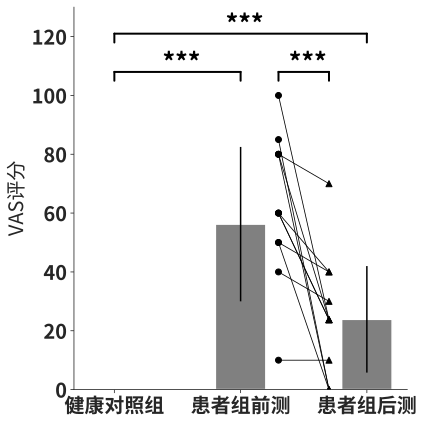

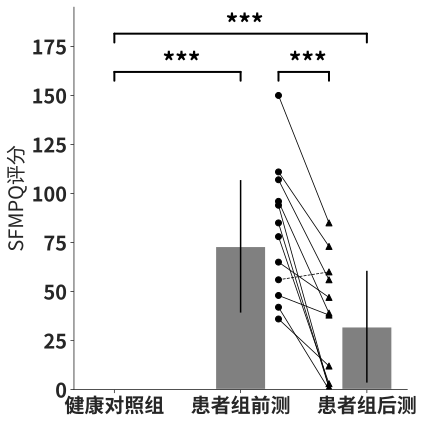

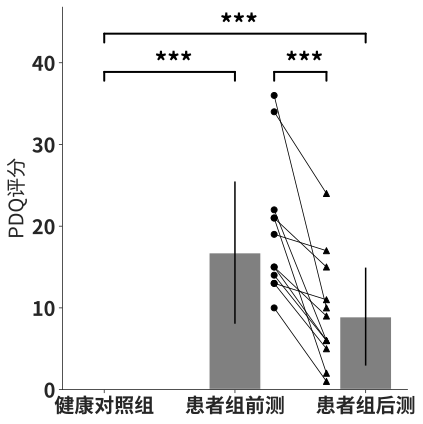

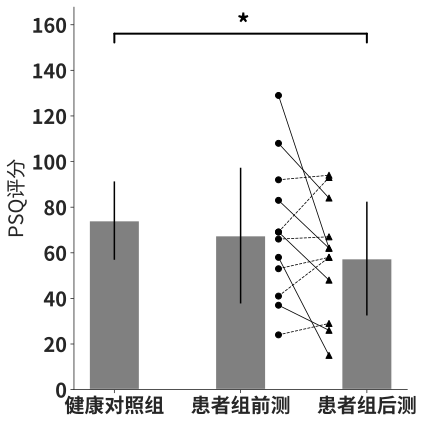

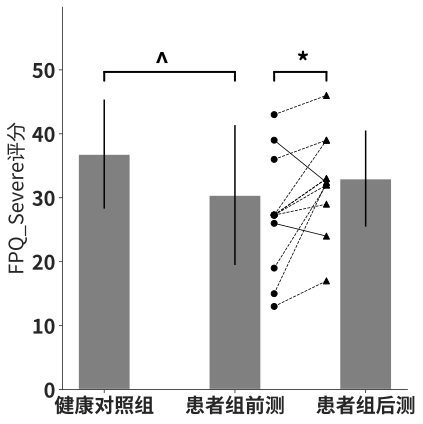

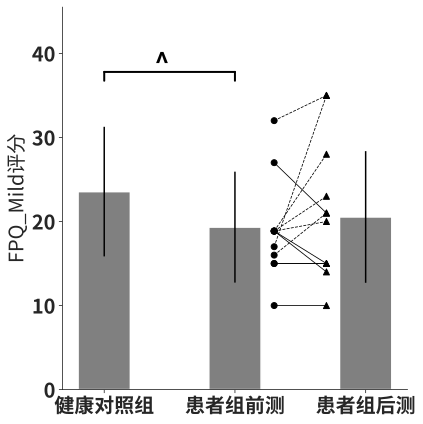

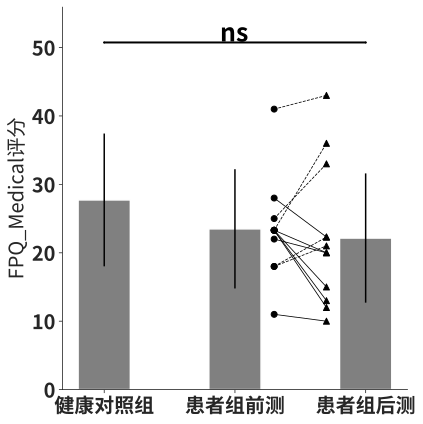

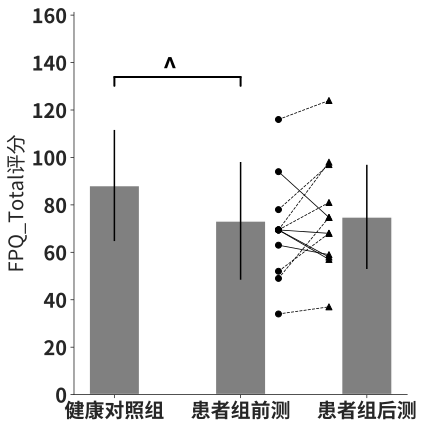

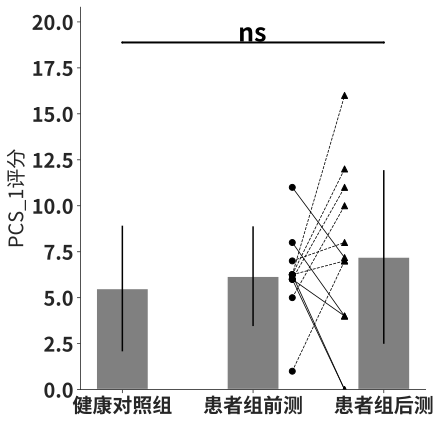

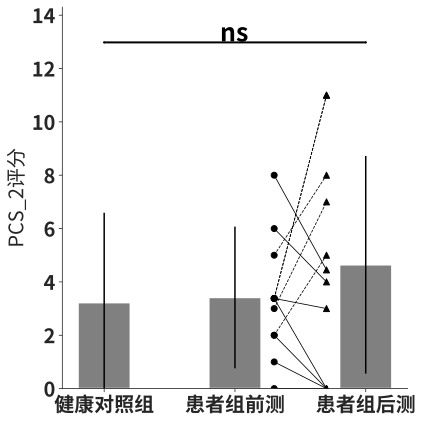

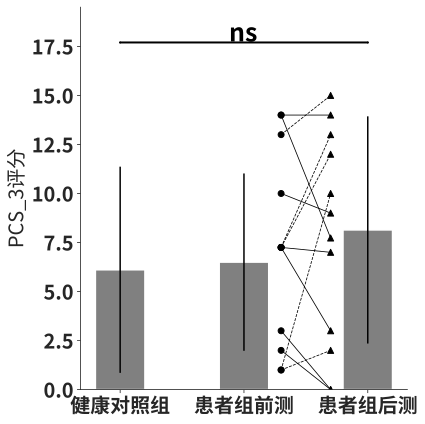

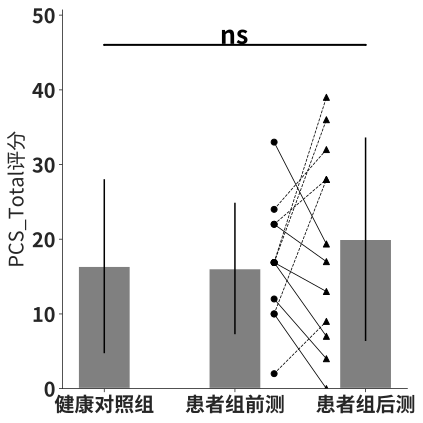

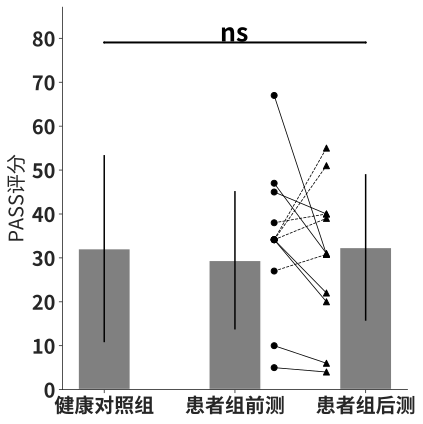

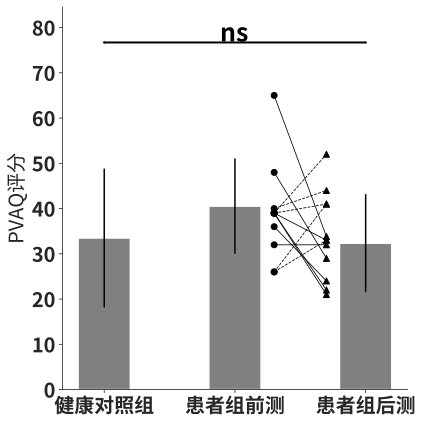

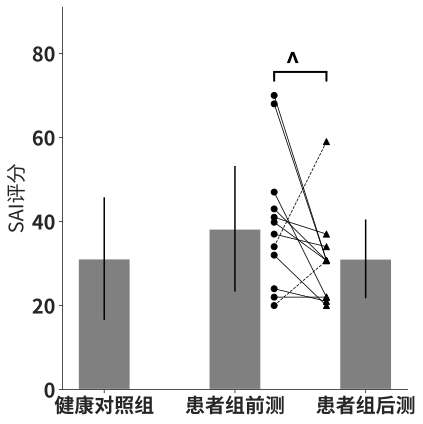

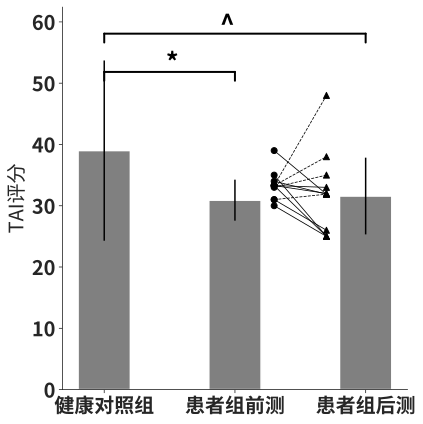

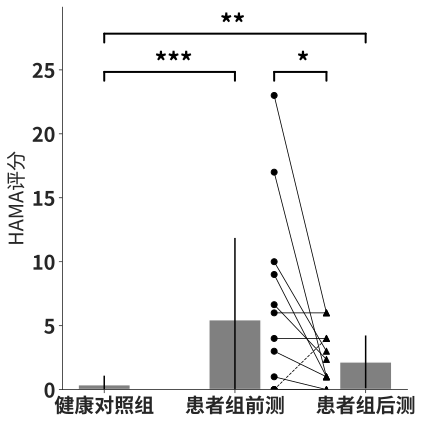

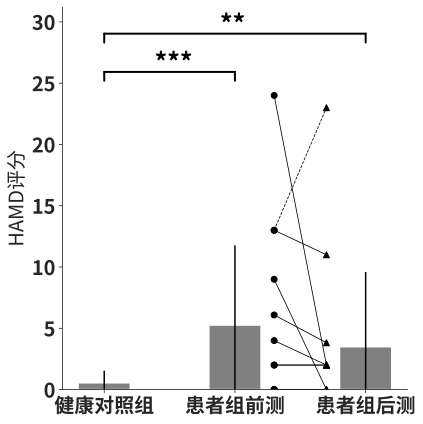

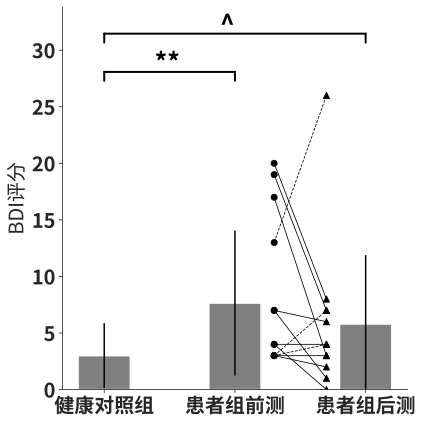

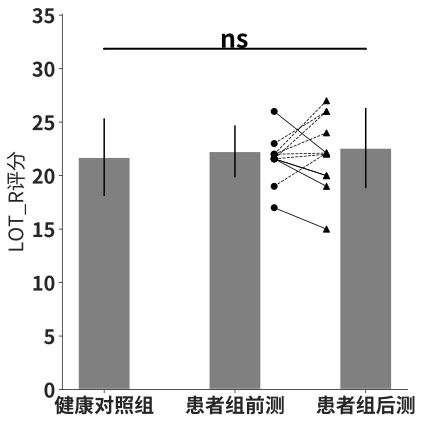

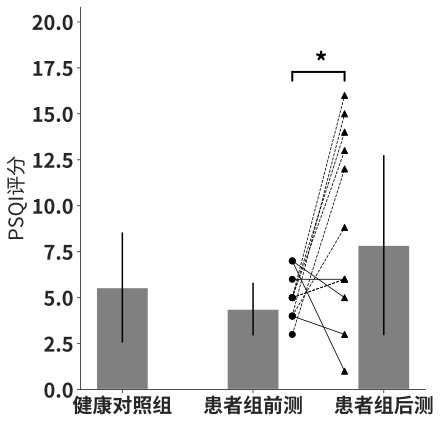

In [36]:
%timeit
i = 0
for scale in scales:
    i+=1
    '''parameters setup'''
    size = 3
    x = np.arange(size)
    total_width, n = 0.8, 2
    width = total_width / n
    x = x - (total_width - width) / 2
    labels = ['健康对照组', '患者组前测', '患者组后测']
    '''获取bar图所需值'''
    scale_mean=[get_mean(df, scale) for df in [Scale_hc,Scale_pt,Scale_pt_2]]
    scale_std= [get_std(df, scale) for df in [Scale_hc,Scale_pt,Scale_pt_2]]
    '''figure setup'''
    plt.figure(figsize=(6,6),dpi=300)
    sns.set_style("white")
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["font.family"] = 'Noto Sans CJK JP'
    plt.bar(x, scale_mean,  width=width, yerr = scale_std, tick_label=labels, linewidth=1.5,label='Control',color='gray')
     
    '''plot trend'''
    y_max = 0
    for pt in pre_test.index:

        y1=pre_test.loc[pt,scale]
        plt.plot(1.1,y1,'o',color='black')
        y2=post_test.loc[pt,scale]
        plt.plot(1.5,y2,'^',color='black')
        
        y_max = get_max(y_max, y1)
        y_max = get_max(y_max, y2)
        
        linetp='-' if y2<y1 or y2==y1 else 'dashed'

        plt.plot([1.1,1.5],
                 [y1,y2],linestyle=linetp, color = 'black',linewidth=0.8)
    '''plot significance'''
    marker=True
    # 患者12时点
    symbol = get_sig(pt12_contrast_result, scale)[1]
    if symbol:
        plot_sig(1.1,1.5,y_max*1.05,y_max*1.08,symbol);marker=False
    # 健康对时点1
    symbol = get_sig(hc_pt_result,scale)[1]
    if symbol:
        plot_sig(-0.2,0.8,y_max*1.05,y_max*1.08,symbol);marker=False
    # 健康对时点2
    symbol = get_sig(hc_pt_result_2,scale)[1]
    if symbol:
        plot_sig(-0.2,1.8,y_max*1.18,y_max*1.21,symbol);marker=False
    if marker:
        plot_sig(-0.2,1.8,y_max*1.18,y_max*1.18, 'ns')

    '''decorate image'''
    ax = plt.gca()      #gca='get current axis'
    # 将右边和上边的边框（脊）的颜色去掉
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # 绑定x轴和y轴
    
    font2 = {'weight' : 'normal','size'   : 20, }
    plt.ylabel('{}评分'.format(scale),font=font2)
    plt.tick_params(labelsize=20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.ylim(0, y_max*1.3)
    plt.tight_layout()
    save_fig("均值比较{}".format(scale))


# 关联分析



## **患者第一个时点组内的关联分析**  
P_010缺失VAS SFMPQ 数据，剔除了  
每一对数据，如果有一个缺失就剔除，防止overfitting


In [30]:
Scale_corr = Scale_Filtered[Scale_Filtered['timepoint'].isin([1])].drop(index='P_010')[columns_for_anal+columns_neo]
Scale_corr['Age'] = get_patinet_info(Scale_corr, 'Age')

只用患者的数据做关联分析

In [31]:
# save_table(pt_p_matrix, 'pt_p_matrix')
pt_p_matrix

VAS  SFMPQ    PDQ    PSQ  FPQ_Severe  FPQ_Mild  FPQ_Medical  \
VAS         0.0000 0.0001 0.0057 0.0129      0.4102    0.1371       0.4469   
SFMPQ       0.0001 0.0000 0.0004 0.0213      0.6150    0.1199       0.4004   
PDQ         0.0057 0.0004 0.0000 0.0546      0.8070    0.4536       0.4229   
PSQ         0.0129 0.0213 0.0546 0.0000      0.0464    0.2639       0.4257   
FPQ_Severe  0.4102 0.6150 0.8070 0.0464      0.0000    0.0045       0.0078   
FPQ_Mild    0.1371 0.1199 0.4536 0.2639      0.0045    0.0000       0.0000   
FPQ_Medical 0.4469 0.4004 0.4229 0.4257      0.0078    0.0000       0.0000   
FPQ_Total   0.2995 0.3477 0.5487 0.1522      0.0001    0.0000       0.0000   
PCS_1       0.7008 0.4364 0.9804 0.6210      0.5678    0.1236       0.1087   
PCS_2       0.5912 0.9441 0.5905 0.5215      0.6804    0.3625       0.2030   
PCS_3       0.8507 0.7035 0.5071 0.9284      0.6405    0.4427       0.2255   
PCS_Total   0.8766 0.6817 0.8636 0.7634      0.5829    0.2453       0.1203   
PASS        0.4649 0.1796 0.3344 0.5593      0.8230    0.3658       0.2875   
PVAQ        0.7527 0.3306 0.8244 0.6232      0.8636    0.5930       0.5978   
SAI         0.0172 0.0024 0.0752 0.0016      0.0068    0.1069       0.2297   
TAI         0.0164 0.0471 0.0056 0.0612      0.8367    0.4445       0.5211   
HAMA        0.4671 0.0182 0.5145 0.9596      0.5680    0.5836       0.8475   
HAMD        0.7928 0.1440 0.9978 0.6932      0.3410    0.8526       0.6391   
BDI         0.0151 0.0166 0.2671 0.2170      0.2135    0.2607       0.8605   
LOT_R       0.7089 0.7450 0.7297 0.4819      0.1066    0.3066       0.2560   
PSQI        0.8773 0.8202 0.9015 0.3236      0.5362    0.8620       0.7358   
NEO_1       0.0644 0.1278 0.2105 0.3621      0.1114    0.0328       0.1257   
NEO_2       0.1408 0.4235 0.7395 0.2063      0.0248    0.0732       0.1245   
NEO_3       0.4740 0.7710 0.8866 0.8783      0.9497    0.7706       0.7117   
NEO_4       0.4358 0.2850 0.6131 0.1940      0.2274    0.3917       0.3225   
NEO_5       0.4480 0.1172 0.8511 0.9004      0.7162    0.3438       0.7603   

             FPQ_Total  PCS_1  PCS_2  PCS_3  PCS_Total   PASS   PVAQ    SAI  \
VAS             0.2995 0.7008 0.5912 0.8507     0.8766 0.4649 0.7527 0.0172   
SFMPQ           0.3477 0.4364 0.9441 0.7035     0.6817 0.1796 0.3306 0.0024   
PDQ             0.5487 0.9804 0.5905 0.5071     0.8636 0.3344 0.8244 0.0752   
PSQ             0.1522 0.6210 0.5215 0.9284     0.7634 0.5593 0.6232 0.0016   
FPQ_Severe      0.0001 0.5678 0.6804 0.6405     0.5829 0.8230 0.8636 0.0068   
FPQ_Mild        0.0000 0.1236 0.3625 0.4427     0.2453 0.3658 0.5930 0.1069   
FPQ_Medical     0.0000 0.1087 0.2030 0.2255     0.1203 0.2875 0.5978 0.2297   
FPQ_Total       0.0000 0.2201 0.3801 0.3997     0.2711 0.4703 0.7908 0.0461   
PCS_1           0.2201 0.0000 0.0062 0.1255     0.0029 0.0517 0.0330 0.7922   
PCS_2           0.3801 0.0062 0.0000 0.0261     0.0002 0.0094 0.0030 0.8646   
PCS_3           0.3997 0.1255 0.0261 0.0000     0.0002 0.0009 0.0874 0.8962   
PCS_Total       0.2711 0.0029 0.0002 0.0002     0.0000 0.0006 0.0096 0.9664   
PASS            0.4703 0.0517 0.0094 0.0009     0.0006 0.0000 0.0021 0.7938   
PVAQ            0.7908 0.0330 0.0030 0.0874     0.0096 0.0021 0.0000 0.9849   
SAI             0.0461 0.7922 0.8646 0.8962     0.9664 0.7938 0.9849 0.0000   
TAI             0.5972 0.5596 0.5907 0.3760     0.9311 0.3567 0.9916 0.4763   
HAMA            0.9536 0.0244 0.0783 0.1833     0.0534 0.0313 0.0238 0.1392   
HAMD            0.5117 0.0235 0.0353 0.2285     0.0530 0.0489 0.0154 0.8603   
BDI             0.3688 0.7242 0.2786 0.9475     0.6855 0.7185 0.9474 0.0109   
LOT_R           0.1702 0.5060 0.9827 0.9981     0.8445 0.6384 0.5281 0.0357   
PSQI            0.9245 0.6211 0.5474 0.7033     0.8733 0.8398 0.4925 0.8703   
NEO_1           0.0657 0.6574 0.8024 0.7507     0.8988 0.6801 0.6482 0.3936   
NEO_2           0.0395 0.9116 0.7539 0.7941     0.7882 0.5311 0.5938 0.0065   
NEO_3       

In [32]:
# Figure settings
large = 22; med = 16; small = 12
params = {'axes.titlesize': large, 'legend.fontsize': med,  'figure.figsize': (16, 10), 'axes.labelsize': med,
          'axes.titlesize': med,   'xtick.labelsize': med,  'ytick.labelsize': med,  'figure.titlesize': large}
def heatmap_setup(params,figsize=(10,8)):
    plt.figure(figsize=figsize, dpi= 80)
    plt.rcParams.update(params)
    plt.style.use('seaborn-whitegrid')
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False 
    sns.set(font_scale=1)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()

<AxesSubplot:>

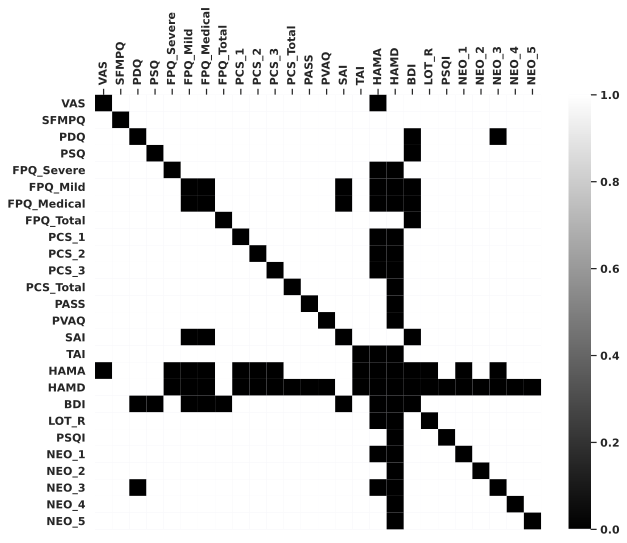

In [33]:
heatmap_setup(params)
sns.heatmap(pt_norm_matrix, cmap='gray')
#save_fig("关联分析 多元正态性检验结果")

In [34]:
#save_table(pt_p_matrix,"关联分析 相关p值")
#save_table(pt_coefficient_matrix,"关联分析 相关系数")
#save_table(pt_p_matrix_perm,"关联分析  相关p值带置换检验")

<AxesSubplot:>

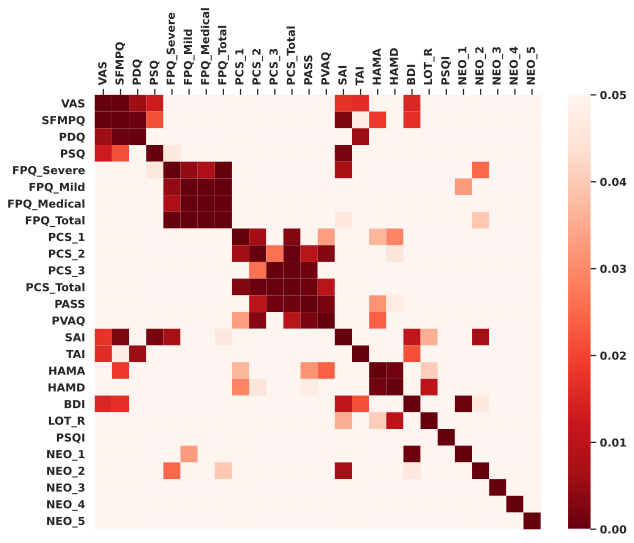

In [35]:
heatmap_setup(params)
sns.heatmap(pt_p_matrix_perm, cmap='Reds_r',vmax=0.05)
#save_fig("关联分析 带有置换检验p值_thresh")

Pearson 关联分析结果的heatmap

<AxesSubplot:>

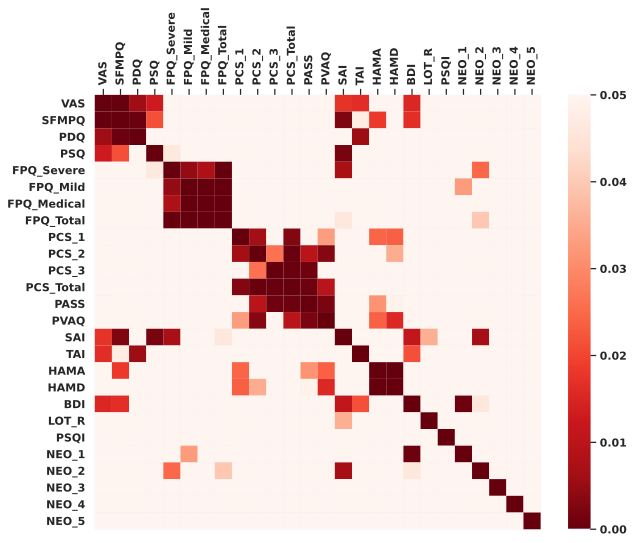

In [36]:
heatmap_setup(params)
sns.heatmap(pt_p_matrix, cmap='Reds_r',vmax=0.05)
#save_fig("关联分析 不带置换检验p值_thresh")

<AxesSubplot:>

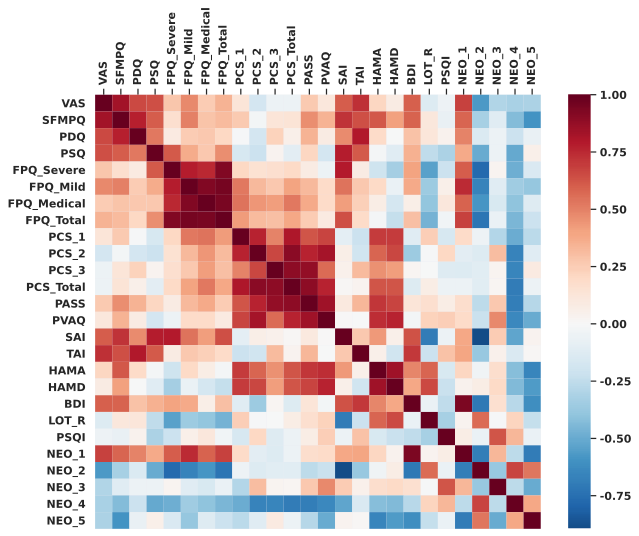

In [37]:
heatmap_setup(params)
sns.heatmap(pt_coefficient_matrix, cmap='RdBu_r', center=0)
#save_fig("关联分析 相关系数")

偏相关分析（年龄作为协变量）结果的heatmap

In [38]:
print("partial correlation result：")
#save_table(pt_p_matrix_partial,"关联分析 偏相关p值")
#save_table(pt_coefficient_matrix_partial,"关联分析 偏相关系数")
pt_p_matrix_partial

partial correlation result：


VAS  SFMPQ    PDQ    PSQ  FPQ_Severe  FPQ_Mild  FPQ_Medical  \
VAS         0.0000 0.0000 0.0000 0.0001      0.0633    0.0049       0.0607   
SFMPQ       0.0000 0.0000 0.0000 0.0002      0.0917    0.0010       0.0096   
PDQ         0.0000 0.0000 0.0000 0.0017      0.0937    0.2186       0.1800   
PSQ         0.0001 0.0002 0.0017 0.0000      0.0005    0.0281       0.0693   
FPQ_Severe  0.0633 0.0917 0.0937 0.0005      0.0000    0.0004       0.0017   
FPQ_Mild    0.0049 0.0010 0.2186 0.0281      0.0004    0.0000       0.0000   
FPQ_Medical 0.0607 0.0096 0.1800 0.0693      0.0017    0.0000       0.0000   
FPQ_Total   0.0251 0.0131 0.1502 0.0050      0.0000    0.0000       0.0000   
PCS_1       0.1963 0.0698 0.1403 0.0388      0.2074    0.0085       0.0018   
PCS_2       0.0366 0.1652 0.0301 0.0187      0.0845    0.1574       0.0427   
PCS_3       0.0981 0.1698 0.1307 0.1548      0.0922    0.2469       0.0679   
PCS_Total   0.0962 0.1654 0.1765 0.0506      0.0990    0.0971       0.0165   
PASS        0.0920 0.0143 0.0534 0.1525      0.0928    0.0857       0.0370   
PVAQ        0.1652 0.0357 0.1973 0.0668      0.0822    0.0914       0.0735   
SAI         0.0002 0.0000 0.0054 0.0000      0.0001    0.0138       0.0687   
TAI         0.0003 0.0013 0.0001 0.0044      0.0316    0.2356       0.1271   
HAMA        0.0203 0.0000 0.0094 0.1499      0.2271    0.0116       0.0029   
HAMD        0.0328 0.0010 0.0238 0.2011      0.1490    0.0798       0.0283   
BDI         0.0001 0.0001 0.0192 0.0127      0.0001    0.0002       0.0061   
LOT_R       0.1786 0.0490 0.0127 0.1967      0.1481    0.0811       0.0356   
PSQI        0.1481 0.1562 0.1631 0.0150      0.0042    0.0975       0.0561   
NEO_1       0.0059 0.0079 0.0486 0.2021      0.0101    0.0016       0.0163   
NEO_2       0.0366 0.0691 0.0686 0.2183      0.0022    0.0200       0.0774   
NEO_3       0.0608 0.1620 0.2232 0.2253      0.1439    0.1634       0.1151   
NEO_4       0.1227 0.0337 0.2427 0.0229      0.0399    0.1226       0.0990   
NEO_5       0.0127 0.0027 0.0724 0.0625      0.0020    0.0009       0.0066   

             FPQ_Total  PCS_1  PCS_2  PCS_3  PCS_Total   PASS   PVAQ    SAI  \
VAS             0.0251 0.1963 0.0366 0.0981     0.0962 0.0920 0.1652 0.0002   
SFMPQ           0.0131 0.0698 0.1652 0.1698     0.1654 0.0143 0.0357 0.0000   
PDQ             0.1502 0.1403 0.0301 0.1307     0.1765 0.0534 0.1973 0.0054   
PSQ             0.0050 0.0388 0.0187 0.1548     0.0506 0.1525 0.0668 0.0000   
FPQ_Severe      0.0000 0.2074 0.0845 0.0922     0.0990 0.0928 0.0822 0.0001   
FPQ_Mild        0.0000 0.0085 0.1574 0.2469     0.0971 0.0857 0.0914 0.0138   
FPQ_Medical     0.0000 0.0018 0.0427 0.0679     0.0165 0.0370 0.0735 0.0687   
FPQ_Total       0.0000 0.0284 0.2103 0.2401     0.1409 0.1651 0.2063 0.0019   
PCS_1           0.0284 0.0000 0.0001 0.0107     0.0000 0.0019 0.0005 0.0126   
PCS_2           0.2103 0.0001 0.0000 0.0008     0.0000 0.0001 0.0000 0.0527   
PCS_3           0.2401 0.0107 0.0008 0.0000     0.0000 0.0000 0.0027 0.0405   
PCS_Total       0.1409 0.0000 0.0000 0.0000     0.0000 0.0000 0.0000 0.0194   
PASS            0.1651 0.0019 0.0001 0.0000     0.0000 0.0000 0.0000 0.1261   
PVAQ            0.2063 0.0005 0.0000 0.0027     0.0000 0.0000 0.0000 0.1708   
SAI             0.0019 0.0126 0.0527 0.0405     0.0194 0.1261 0.1708 0.0000   
TAI             0.0803 0.0331 0.0313 0.0810     0.1487 0.0598 0.2152 0.2386   
HAMA            0.0521 0.0001 0.0013 0.0012     0.0001 0.0000 0.0002 0.0020   
HAMD            0.1527 0.0000 0.0000 0.0004     0.0000 0.0000 0.0000 0.0863   
BDI             0.0001 0.0860 0.0072 0.1952     0.0631 0.1746 0.2072 0.0000   
LOT_R           0.1298 0.0040 0.0596 0.0501     0.0182 0.0173 0.0308 0.0226   
PSQI            0.0174 0.0585 0.1235 0.0716     0.1128 0.2320 0.0742 0.0975   
NEO_1           0.0020 0.1010 0.1643 0.0621     0.1469 0.1638 0.0679 0.1960   
NEO_2           0.0074 0.1858 0.1305 0.1746     0.2353 0.1128 0.0348 0.0015   
NEO_3       

<AxesSubplot:>

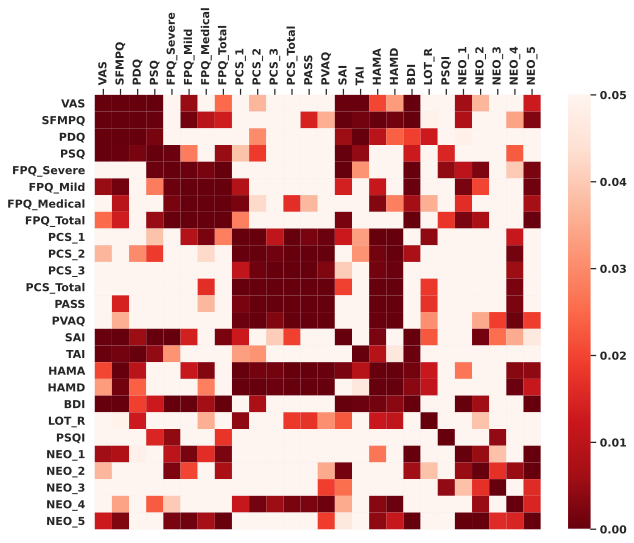

In [39]:
heatmap_setup(params)
sns.heatmap(pt_p_matrix_partial, cmap='Reds_r',vmax=0.05)
#save_fig("关联分析 偏相关p值_thersh")

<AxesSubplot:>

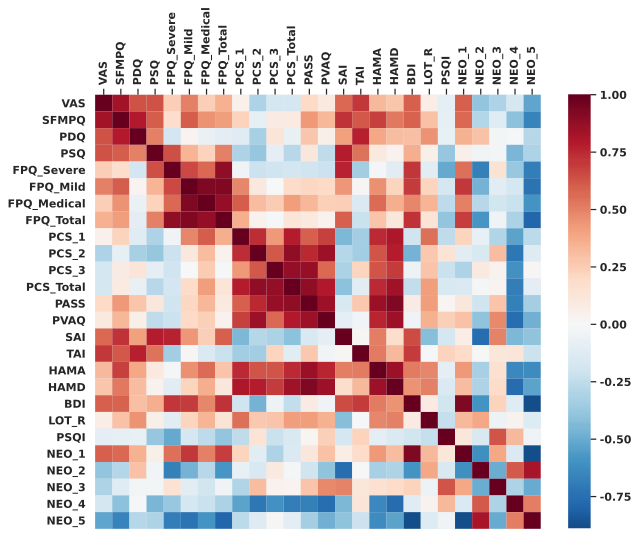

In [40]:
heatmap_setup(params)
sns.heatmap(pt_coefficient_matrix_partial, cmap='RdBu_r', center=0)
#save_fig("关联分析 偏相关系数")

## 患者行为评分与其损伤情况的关联性
患者疼痛评分与损伤位置、损伤节段数、ASIA评分的关联性,因为样本数较少，因此将分类变量转化为二分变量   
* ASIA评分分为D组/非D组* ASIA评分分为D组/非D组
* 损伤位置分为颈髓损伤包括C6/7与不包括两组  
P_006损伤部位记录为C6,根据其他患者的情况来看，损伤节段少的位置较为靠上，故将其归入损伤不包括C6/7的一组中
* 损伤节段数分为3以上/3及以下


In [41]:
Scale_corr_1= Scale_Filtered[Scale_Filtered['timepoint'].isin([1])].drop(index='P_010')[columns_for_anal] # Reorder
Scale_corr_1[['Age','ASIA','Injured_seg','Seg_count']] = get_patinet_info(Scale_corr_1, ['Age','ASIA_Pretest','Injured_Segment','Count_of_Injured_Segment'])
missing_pt_corr = pd.DataFrame(Scale_corr_1.isnull().sum(axis=0), columns=['关联分析']).drop(index=['timepoint']).T

In [42]:
fill_na_mean(Scale_corr_1)
for i in Scale_corr_1.index:
    Scale_corr_1.loc[i,'ASIA_Group'] = 1 if Scale_corr_1.loc[i, 'ASIA']=='D' else 0  # AISA_Group: 1 represents D
    Scale_corr_1.loc[i,'PSQ_Group'] = 1 if Scale_corr_1.loc[i, 'PSQ'] > Scale_corr_1['PSQ'].mean() else 0 # PSQ_Group: 1 represents higher than average


In [46]:
for a,b in ((1,2),(2,4)):
    print(a,b)

1 2
2 4


In [47]:
for factor, contrast_table in [('ASIA_Group',asia),('Injured_seg',injured_seg),('Seg_count',seg_count),('PSQ_Group',psq)]:
    group1 = Scale_corr_1[Scale_corr_1[factor]==1] # 大于3、包含C6/7、PSQ高于平均、D级
    group2 = Scale_corr_1[Scale_corr_1[factor]==0] # 不大于3、不包含C6/7、PSQ低于平均、非D级
    g1_describe = group1.describe()
    g2_describe = group2.describe()
    result_df = create_result_df(g1_describe, ['患者后测数据','健康受试者'])
    create_describe([g1_describe,g2_describe],result_df)
    result_output=result_df.join(contrast_table)
    # save_table(result_output,'{}_result'.format(factor))

### 两组间进行两独立样本t检验

In [48]:
print("不同损伤节段组间的差异：")
injured_seg.columns = ['组别1正态性检验','组别1正态性检验p值','组别2正态性检验','组别2正态性检验p值','方差齐性检验','方差齐性检验p值','t检验','t检验p值','独立样本置换检验p值','协方差分析p值']
#save_table(injured_seg,'injured_seg')

injured_seg

不同损伤节段组间的差异：


组别1正态性检验  组别1正态性检验p值  组别2正态性检验  组别2正态性检验p值  方差齐性检验  方差齐性检验p值  \
VAS            0.9693      0.8844    0.7790      0.0377  0.0251    0.8765   
SFMPQ          0.9066      0.2585    0.8330      0.1140  0.1891    0.6703   
PDQ            0.9131      0.3031    0.9437      0.6889  0.5468    0.4718   
PSQ            0.9416      0.5707    0.8610      0.1926  0.6122    0.4470   
FPQ_Severe     0.9040      0.2423    0.9400      0.6595  1.9933    0.1798   
FPQ_Mild       0.8707      0.1019    0.9252      0.5434  0.2360    0.6346   
FPQ_Medical    0.8728      0.1078    0.9778      0.9398  1.9320    0.1863   
FPQ_Total      0.9173      0.3352    0.9132      0.4579  1.2448    0.2833   
PCS_1          0.9330      0.4785    0.6399      0.0014  3.7915    0.0719   
PCS_2          0.9130      0.3026    0.8900      0.3181  2.2331    0.1573   
PCS_3          0.9107      0.2859    0.8722      0.2351  0.8381    0.3754   
PCS_Total      0.9625      0.8137    0.8924      0.3310  1.6486    0.2200   
PASS           0.9419      0.5742    0.7801      0.0386  2.5200    0.1347   
PVAQ           0.8592      0.0747    0.8760      0.2510  1.3545    0.2639   
SAI            0.8712      0.1032    0.9560      0.7883  0.6552    0.4318   
TAI            0.8507      0.0592    0.8850      0.2929  0.0154    0.9029   
HAMA           0.8418      0.0464    0.9408      0.6660  2.5029    0.1360   
HAMD           0.8080      0.0182    0.9902      0.9897  1.9987    0.1793   
BDI            0.7815      0.0086    0.8110      0.0737  0.0006    0.9811   
LOT_R          0.8636      0.0841    0.8591      0.1862  0.2348    0.6355   
PSQI           0.8775      0.1221    0.9774      0.9379  1.3781    0.2600   

                t检验  t检验p值  独立样本置换检验p值  协方差分析p值  
VAS         -0.7997 0.4372      0.4572   0.3605  
SFMPQ        0.5694 0.5781      0.5798   0.6368  
PDQ          1.0370 0.3173      0.3326   0.4142  
PSQ         -1.4361 0.1729      0.1600   0.1432  
FPQ_Severe  -0.6105 0.5513      0.5498   0.2579  
FPQ_Mild    -0.0215 0.9832      0.9902   0.6504  
FPQ_Medical  0.4214 0.6799      0.7028   0.9354  
FPQ_Total   -0.1153 0.9099      0.9232   0.4700  
PCS_1        0.5278 0.6059      0.6408   0.7132  
PCS_2        0.1756 0.8631      0.8832   0.9974  
PCS_3        0.9979 0.3353      0.3560   0.4224  
PCS_Total    0.7395 0.4718      0.4758   0.5882  
PASS        -0.1444 0.8873      0.8918   0.7872  
PVAQ        -0.1154 0.9098      0.9244   0.8775  
SAI          0.0562 0.9560      0.9656   0.9085  
TAI         -0.2066 0.8393      0.8534   0.6961  
HAMA         0.8041 0.4348      0.4606   0.3934  
HAMD         0.5258 0.6073      0.6382   0.4783  
BDI         -0.0774 0.9394      0.9596   0.9207  
LOT_R        0.0254 0.9801      0.9998   0.6905  
PSQI        -0.1737 0.8646      0.9354   0.7248

In [49]:
print("不同损伤节段数组间的差异：")
seg_count.columns = ['组别1正态性检验','组别1正态性检验p值','组别2正态性检验','组别2正态性检验p值','方差齐性检验','方差齐性检验p值','t检验','t检验p值','独立样本置换检验p值','协方差分析p值']
#save_table(seg_count,'seg_count')
seg_count

不同损伤节段数组间的差异：


组别1正态性检验  组别1正态性检验p值  组别2正态性检验  组别2正态性检验p值  方差齐性检验  方差齐性检验p值  \
VAS            0.9764      0.9401    0.8945      0.2217  0.6181    0.4448   
SFMPQ          0.9272      0.5272    0.9589      0.7862  0.2662    0.6139   
PDQ            0.9278      0.5323    0.9067      0.2934  2.5021    0.1360   
PSQ            0.9478      0.7098    0.9480      0.6677  0.0001    0.9909   
FPQ_Severe     0.8672      0.1754    0.9414      0.5965  3.0155    0.1044   
FPQ_Mild       0.9030      0.3496    0.9086      0.3065  1.2679    0.2791   
FPQ_Medical    0.9138      0.4229    0.9175      0.3723  4.6954    0.0480   
FPQ_Total      0.9383      0.6238    0.9390      0.5710  3.2496    0.0930   
PCS_1          0.9365      0.6078    0.8844      0.1746  4.8080    0.0457   
PCS_2          0.9110      0.4029    0.9666      0.8645  3.6263    0.0776   
PCS_3          0.9476      0.7082    0.9239      0.4257  0.3929    0.5408   
PCS_Total      0.9444      0.6786    0.9202      0.3940  3.2102    0.0948   
PASS           0.9692      0.8929    0.8997      0.2504  2.5684    0.1313   
PVAQ           0.9021      0.3438    0.8976      0.2385  1.8220    0.1985   
SAI            0.8558      0.1387    0.9590      0.7883  0.0138    0.9082   
TAI            0.8374      0.0939    0.9207      0.3979  0.3435    0.5671   
HAMA           0.9076      0.3796    0.7328      0.0034  0.0348    0.8547   
HAMD           0.8343      0.0878    0.9018      0.2629  0.9745    0.3403   
BDI            0.7773      0.0243    0.7775      0.0113  0.0868    0.7727   
LOT_R          0.7533      0.0137    0.8550      0.0845  0.1488    0.7055   
PSQI           0.9189      0.4612    0.9749      0.9329  0.2458    0.6277   

                t检验  t检验p值  独立样本置换检验p值  协方差分析p值  
VAS         -0.6142 0.5489      0.5534   0.4575  
SFMPQ        0.6159 0.5478      0.5536   0.6082  
PDQ          1.2209 0.2423      0.2500   0.3274  
PSQ         -1.0618 0.3063      0.3128   0.2591  
FPQ_Severe  -0.1168 0.9087      0.9106   0.5754  
FPQ_Mild     0.6308 0.5383      0.5362   0.7651  
FPQ_Medical  0.7183 0.4971      0.4442   0.6352  
FPQ_Total    0.4096 0.6883      0.6842   0.9677  
PCS_1        0.5050 0.6303      0.6312   0.6881  
PCS_2        0.4484 0.6607      0.6950   0.7961  
PCS_3        0.6328 0.5371      0.5216   0.6576  
PCS_Total    0.6524 0.5247      0.5296   0.6561  
PASS         0.3784 0.7108      0.7214   0.8143  
PVAQ         0.6759 0.5101      0.5532   0.5500  
SAI         -0.3076 0.7629      0.7646   0.6236  
TAI         -0.1679 0.8691      0.8936   0.7169  
HAMA         0.3584 0.7254      0.7412   0.6651  
HAMD         0.8181 0.4270      0.4482   0.3105  
BDI          0.3029 0.7664      0.7714   0.7925  
LOT_R        0.8900 0.3885      0.4360   0.1498  
PSQI         0.5128 0.6161      0.6588   0.7460

In [50]:
print("不同ASIA评分组间的差异：")
asia.columns = ['组别1正态性检验','组别1正态性检验p值','组别2正态性检验','组别2正态性检验p值','方差齐性检验','方差齐性检验p值','t检验','t检验p值','独立样本置换检验p值','协方差分析p值']
#save_table(asia,'asia')
asia

不同ASIA评分组间的差异：


组别1正态性检验  组别1正态性检验p值  组别2正态性检验  组别2正态性检验p值  方差齐性检验  方差齐性检验p值  \
VAS            0.9274      0.3537    0.9797      0.9004  1.2419    0.2839   
SFMPQ          0.9639      0.8374    0.9166      0.5182  0.2100    0.6538   
PDQ            0.9376      0.4671    0.9060      0.4616  4.8611    0.0447   
PSQ            0.9405      0.5048    0.7501      0.0387  0.0710    0.7938   
FPQ_Severe     0.9373      0.4635    0.7286      0.0239  0.3737    0.5508   
FPQ_Mild       0.9025      0.1710    0.8499      0.2260  0.0030    0.9568   
FPQ_Medical    0.8434      0.0304    0.7123      0.0160  0.0329    0.8588   
FPQ_Total      0.9476      0.6016    0.8354      0.1822  0.0911    0.7672   
PCS_1          0.8923      0.1263    0.6298      0.0012  2.1568    0.1640   
PCS_2          0.9390      0.4855    0.6298      0.0012  3.0038    0.1050   
PCS_3          0.9022      0.1694    0.6298      0.0012  2.1638    0.1634   
PCS_Total      0.9517      0.6619    0.6298      0.0012  4.3955    0.0547   
PASS           0.9558      0.7220    0.6298      0.0012  1.9237    0.1871   
PVAQ           0.9033      0.1747    0.6298      0.0012  1.9912    0.1801   
SAI            0.9090      0.2073    0.8974      0.4184  2.1770    0.1622   
TAI            0.9478      0.6055    0.6298      0.0012  0.0007    0.9797   
HAMA           0.8385      0.0266    0.6763      0.0059  0.0609    0.8087   
HAMD           0.7816      0.0058    0.8979      0.4206  0.5120    0.4861   
BDI            0.6512      0.0003    0.9815      0.9109  0.0032    0.9558   
LOT_R          0.9385      0.4785    0.6298      0.0012  2.6560    0.1254   
PSQI           0.9531      0.6824    0.8274      0.1612  2.2500    0.1558   

                t检验  t检验p值  独立样本置换检验p值  协方差分析p值  
VAS         -2.1309 0.0513      0.0560   0.0586  
SFMPQ       -3.7062 0.0024      0.0008   0.0034  
PDQ         -1.8265 0.1512      0.0298   0.0205  
PSQ         -1.6054 0.1307      0.1364   0.1472  
FPQ_Severe  -1.2830 0.2203      0.2246   0.1787  
FPQ_Mild    -1.5922 0.1337      0.1308   0.0853  
FPQ_Medical -1.0219 0.3241      0.3462   0.1591  
FPQ_Total   -1.3696 0.1924      0.2014   0.0986  
PCS_1       -0.0850 0.9335      0.9336   0.9670  
PCS_2        0.3736 0.7143      0.7452   0.6741  
PCS_3       -0.7777 0.4497      0.4464   0.4754  
PCS_Total   -0.3125 0.7593      0.7708   0.7963  
PASS        -0.4957 0.6278      0.6442   0.6576  
PVAQ         0.3889 0.7032      0.7296   0.7038  
SAI         -3.5730 0.0031      0.0062   0.0031  
TAI         -1.5372 0.1465      0.1486   0.1556  
HAMA        -1.5392 0.1461      0.1430   0.1495  
HAMD        -0.2613 0.7976      0.8204   0.7574  
BDI         -2.2095 0.0443      0.0374   0.0535  
LOT_R       -0.0850 0.9334      0.9376   0.8430  
PSQI         0.7932 0.4409      0.4990   0.4063

In [51]:
print("不同PSQ组间的差异：")
psq.columns = ['组别1正态性检验','组别1正态性检验p值','组别2正态性检验','组别2正态性检验p值','方差齐性检验','方差齐性检验p值','t检验','t检验p值','独立样本置换检验p值','协方差分析p值']
#save_table(psq,'psq')
psq

不同PSQ组间的差异：


组别1正态性检验  组别1正态性检验p值  组别2正态性检验  组别2正态性检验p值  方差齐性检验  方差齐性检验p值  \
VAS            0.9274      0.3537    0.9797      0.9004  1.2419    0.2839   
SFMPQ          0.9639      0.8374    0.9166      0.5182  0.2100    0.6538   
PDQ            0.9376      0.4671    0.9060      0.4616  4.8611    0.0447   
PSQ            0.9405      0.5048    0.7501      0.0387  0.0710    0.7938   
FPQ_Severe     0.9373      0.4635    0.7286      0.0239  0.3737    0.5508   
FPQ_Mild       0.9025      0.1710    0.8499      0.2260  0.0030    0.9568   
FPQ_Medical    0.8434      0.0304    0.7123      0.0160  0.0329    0.8588   
FPQ_Total      0.9476      0.6016    0.8354      0.1822  0.0911    0.7672   
PCS_1          0.8923      0.1263    0.6298      0.0012  2.1568    0.1640   
PCS_2          0.9390      0.4855    0.6298      0.0012  3.0038    0.1050   
PCS_3          0.9022      0.1694    0.6298      0.0012  2.1638    0.1634   
PCS_Total      0.9517      0.6619    0.6298      0.0012  4.3955    0.0547   
PASS           0.9558      0.7220    0.6298      0.0012  1.9237    0.1871   
PVAQ           0.9033      0.1747    0.6298      0.0012  1.9912    0.1801   
SAI            0.9090      0.2073    0.8974      0.4184  2.1770    0.1622   
TAI            0.9478      0.6055    0.6298      0.0012  0.0007    0.9797   
HAMA           0.8385      0.0266    0.6763      0.0059  0.0609    0.8087   
HAMD           0.7816      0.0058    0.8979      0.4206  0.5120    0.4861   
BDI            0.6512      0.0003    0.9815      0.9109  0.0032    0.9558   
LOT_R          0.9385      0.4785    0.6298      0.0012  2.6560    0.1254   
PSQI           0.9531      0.6824    0.8274      0.1612  2.2500    0.1558   

                t检验  t检验p值  独立样本置换检验p值  协方差分析p值  
VAS         -2.1309 0.0513      0.0560   0.0586  
SFMPQ       -3.7062 0.0024      0.0008   0.0034  
PDQ         -1.8265 0.1512      0.0298   0.0205  
PSQ         -1.6054 0.1307      0.1364   0.1472  
FPQ_Severe  -1.2830 0.2203      0.2246   0.1787  
FPQ_Mild    -1.5922 0.1337      0.1308   0.0853  
FPQ_Medical -1.0219 0.3241      0.3462   0.1591  
FPQ_Total   -1.3696 0.1924      0.2014   0.0986  
PCS_1       -0.0850 0.9335      0.9336   0.9670  
PCS_2        0.3736 0.7143      0.7452   0.6741  
PCS_3       -0.7777 0.4497      0.4464   0.4754  
PCS_Total   -0.3125 0.7593      0.7708   0.7963  
PASS        -0.4957 0.6278      0.6442   0.6576  
PVAQ         0.3889 0.7032      0.7296   0.7038  
SAI         -3.5730 0.0031      0.0062   0.0031  
TAI         -1.5372 0.1465      0.1486   0.1556  
HAMA        -1.5392 0.1461      0.1430   0.1495  
HAMD        -0.2613 0.7976      0.8204   0.7574  
BDI         -2.2095 0.0443      0.0374   0.0535  
LOT_R       -0.0850 0.9334      0.9376   0.8430  
PSQI         0.7932 0.4409      0.4990   0.4063

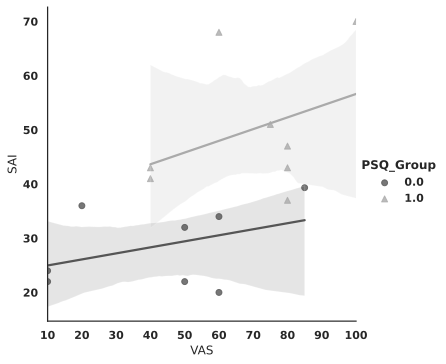

In [52]:
cov ='PSQ_Group'
i = 1
pain ='VAS'
j = 1
emotion ='SAI'
sns.set_style("white")

g = sns.lmplot(y=emotion, x = pain, hue = cov, data=Scale_corr_1, palette='gray',markers=['o','^'])


#plt.savefig('forplot/{}{}{}'.format(cov,i,j), bbox_inches='tight')
# save_fig("交互作用legend")

/home/jzni/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


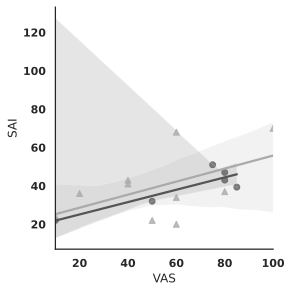

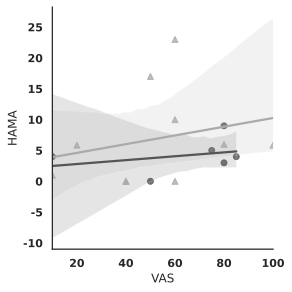

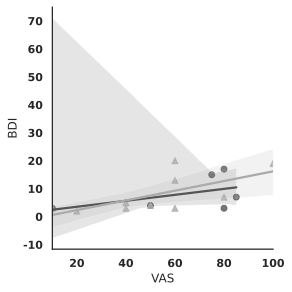

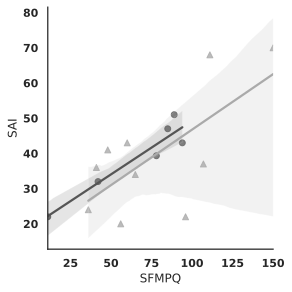

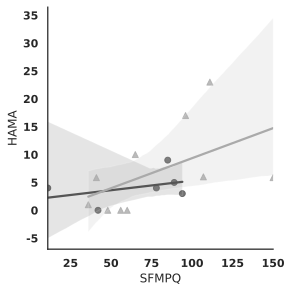

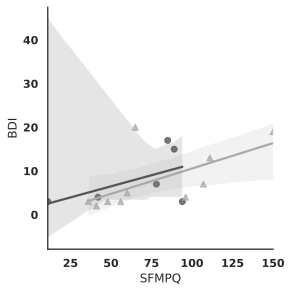

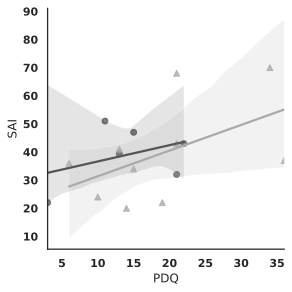

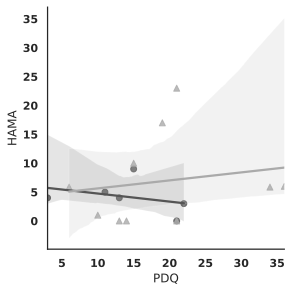

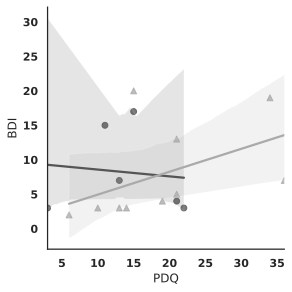

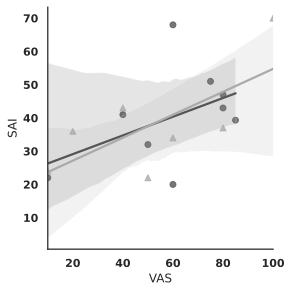

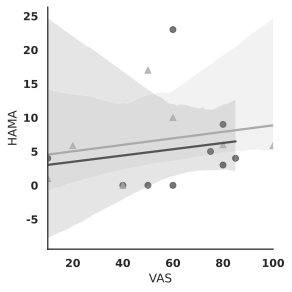

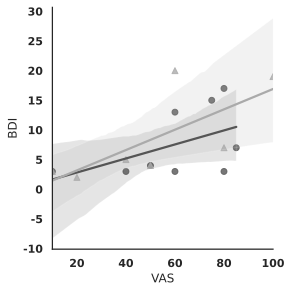

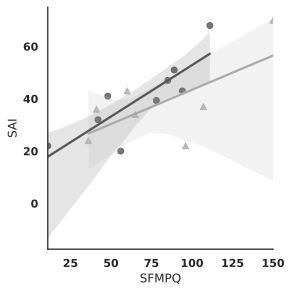

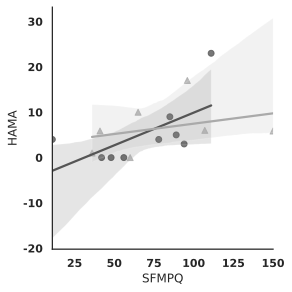

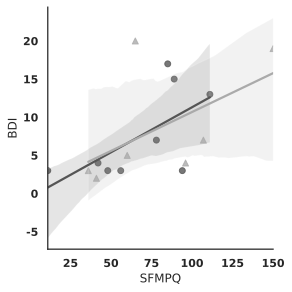

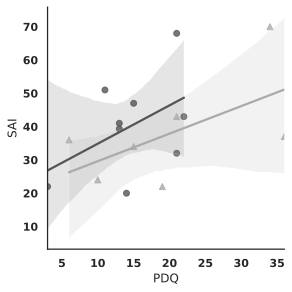

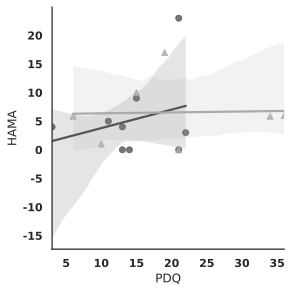

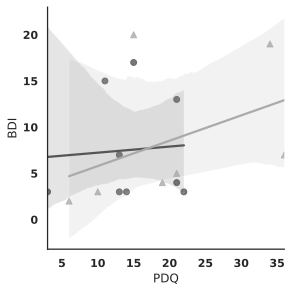

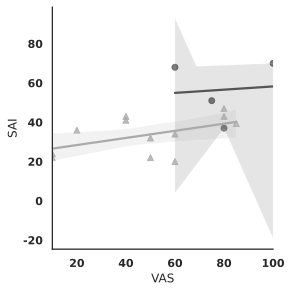

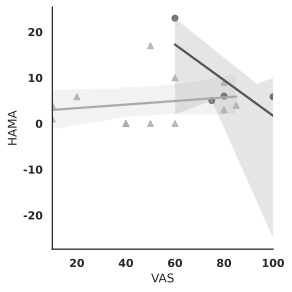

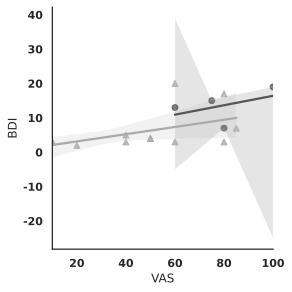

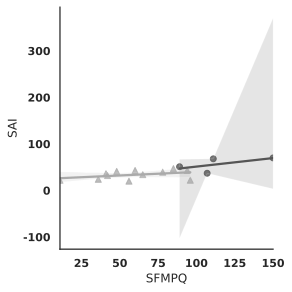

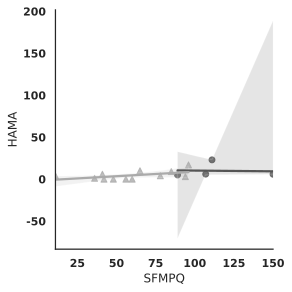

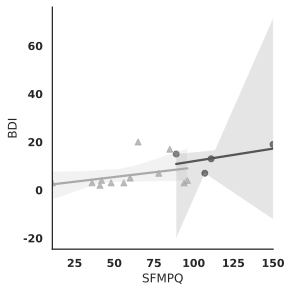

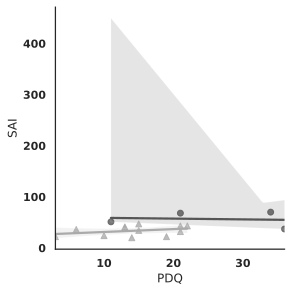

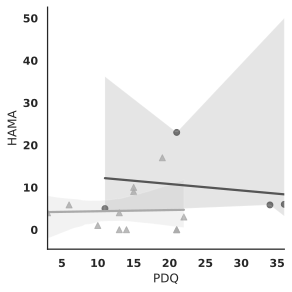

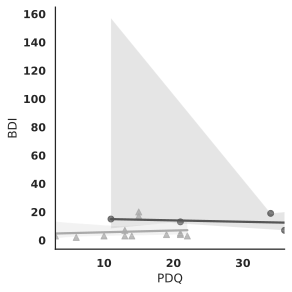

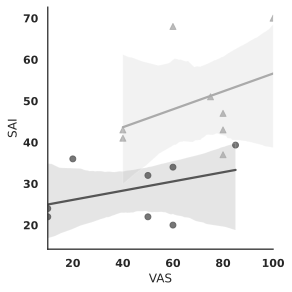

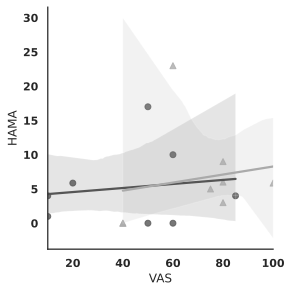

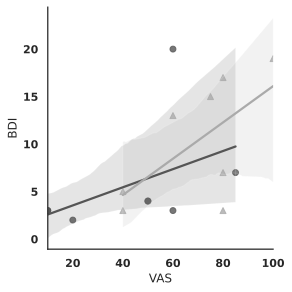

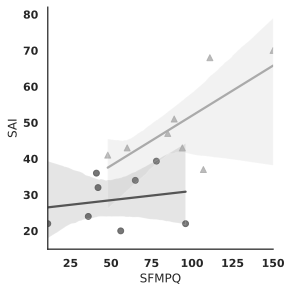

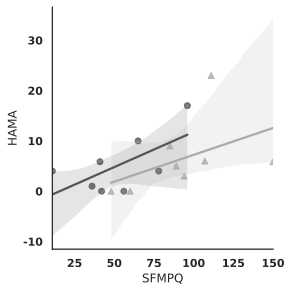

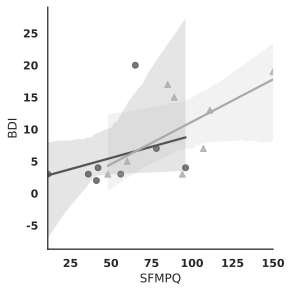

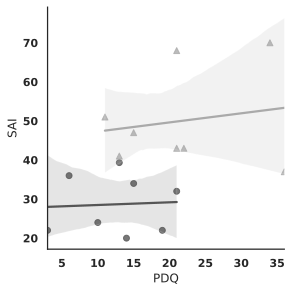

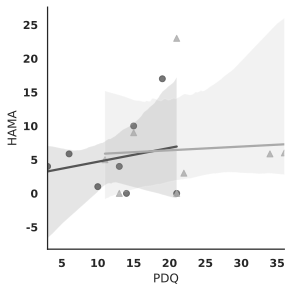

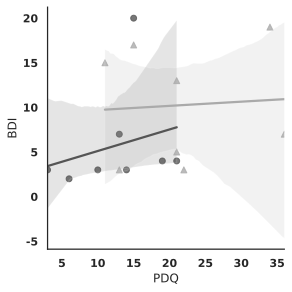

In [53]:
from matplotlib.font_manager import FontProperties
position = []
['Injured_seg', 'Seg_count', 'ASIA_Group', 'PSQ_Group']
['PSQ_Group']
legend_title = ['Injured Segments','Total Number of Injured Segments','ASIA Score','Pain Sensitivity Score']
group2_label = ['Include C6/7','More than 3 segments','Not D','PSQ score higher than average']  # 0
group1_label = ['Not include C6/7','No more than 3 segments','D','PSQ score lower than average']  # 1

for cov in ['Injured_seg', 'Seg_count', 'ASIA_Group', 'PSQ_Group']:
    k = 0
    i = 1
    for pain in ['VAS', 'SFMPQ', 'PDQ']:
        j = 1
        for emotion in ['SAI', 'HAMA', 'BDI']:
            # res = ols("{0}~{1}+C({2})+{1}*C({2})".format(emotion,pain,cov), data = Scale_corr_1).fit()
            # print(res.summary())
            position.append((i,j))
            sns.set_style("white")
        
            g = sns.lmplot(y=emotion, x = pain, hue = cov,legend=False,
                           data=Scale_corr_1, palette='gray',markers=['o','^'],
                          height=4, aspect=1)
            

           
            #plt.savefig('forplot/{}{}{}.svg'.format(cov,pain,emotion), bbox_inches='tight')

            j += 1
        i += 1
    k +=1

FileNotFoundError: [Errno 2] No such file or directory: 'forplot/Injured_seg11.png'

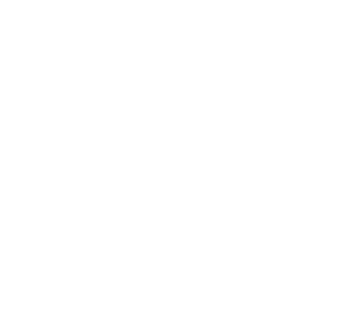

In [54]:
plt.figure(figsize=(20,20), dpi= 500)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('Injured_seg',i,j))
    plt.imshow(im)
    pos += 1
save_fig('交互作用_损伤节段')

FileNotFoundError: [Errno 2] No such file or directory: 'forplot/Seg_count11.png'

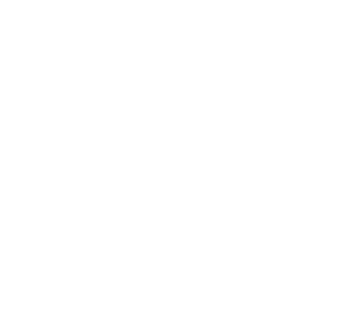

In [55]:
plt.figure(figsize=(20,20), dpi= 500)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('Seg_count',i,j))
    plt.imshow(im)
    pos += 1
save_fig('交互作用_损伤节段数')

FileNotFoundError: [Errno 2] No such file or directory: 'forplot/ASIA_Group11.png'

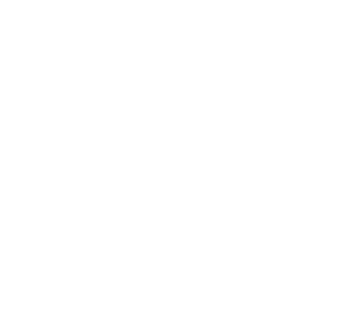

In [56]:
plt.figure(figsize=(20,20), dpi= 500)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('ASIA_Group',i,j))
    plt.imshow(im)
    pos += 1
save_fig('交互作用_ASIA')

In [ ]:
plt.figure(figsize=(20,20), dpi= 500)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('PSQ_Group',i,j))
    plt.imshow(im)
    pos += 1
save_fig('交互作用_疼痛敏感性')

# 中介效应

In [ ]:
print(Scale_corr_1.index)

In [ ]:
pg.mediation_analysis(data=Scale_corr_1, x='VAS', m='PSQ', y='SAI', n_boot=nreps)
#save_table(result, 'VAS-PSQ-SAI')

In [ ]:
pg.mediation_analysis(data=Scale_corr_1, x='VAS', m='SAI', y='PSQ', n_boot=nreps)
# save_table(result, 'VAS-SAI-PSQ')

# VBM结果与行为评分的关联

In [57]:
sql = "SELECT * FROM VBM"
dbcr.execute(sql)
vbm = pd.DataFrame(map(list,dbcr.fetchall()),columns=get_columns('VBM')).set_index(['ID'])

In [62]:
vbm_g2 = vbm[vbm['Group']==1]
vbm_g3 = vbm[vbm['Group']==2]

result_df = create_result_df(vbm_g2.describe(), ['患者前测数据','患者后测数据'])
create_describe([vbm_g2.describe(),vbm_g3.describe()],result_df)
vbm_g23=result_df.join(vbm_contrast_result)
save_table(vbm_g23,'vbm_contrast23')
vbm_g23

患者前测数据     患者后测数据  hc_norm_stat  hc_norm_p  pt_norm_stat  \
Group               1.0±0.0    2.0±0.0           nan        nan           nan   
c1_premotor       0.39±0.08  0.41±0.09        0.9658     0.8624        0.9268   
c1_aMFG           0.34±0.05  0.38±0.04        0.8839     0.0984        0.8886   
c1_rpSTG          0.46±0.08   0.5±0.06        0.9302     0.3827        0.8902   
c2_primary_motor  0.33±0.04  0.32±0.05           nan        nan           nan   
c2_right_thal     0.29±0.02  0.27±0.04           nan        nan           nan   

                  pt_norm_p  levene_stat  levene_p   ind_t  ind_t_p  \
Group                   nan          nan       nan     nan      nan   
c1_premotor          0.4174       0.3213    0.5782 -0.4717   0.6432   
c1_aMFG              0.1634       0.0817    0.7785 -2.0698   0.0540   
c1_rpSTG             0.1707       1.0604    0.3176 -1.0945   0.2890   
c2_primary_motor        nan          nan       nan     nan      nan   
c2_right_thal           nan          nan       nan     nan      nan   

                  perm_ind_t_p  
Group                      nan  
c1_premotor             0.6342  
c1_aMFG                 0.0514  
c1_rpSTG                0.2858  
c2_primary_motor           nan  
c2_right_thal              nan

In [ ]:
#save_table(vbm_contrast_result,"vbm_contrast")

In [ ]:
new_index = [ind[3:] for ind in vbm_p_matrix.index]
vbm_p_matrix.index = new_index
#save_table(vbm_p_matrix,'vbm_correlation_p')

In [ ]:
plt.figure(figsize=(25,3), dpi= 80)

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False  

sns.heatmap(vbm_p_matrix, cmap='Reds_r',annot=True)
#save_fig('vbm_关联p值')

In [ ]:
# 缺失数据统计
missing = pd.concat([missing_pt_1,missing_pt_2, missing_paired, missing_pt_corr])
#save_table(missing,"缺失值")

In [ ]:
# db.close()